# Memorias en CUDA

> Hasta este punto solo hemos visto y usados la memoria global del la GPU, la cual posee limitantes respecto a su uso tales como sus tiempos de acceso, la estructura de acceso, etc. Como veremos a continuación existen diversas capas de memoria que puden ser utilizadas durante la ejecucion de nuestros *kernels*.

>![Alt text](imagen/memLayers.png)
>![Alt text](imagen/memCUDA2.png)


> Algunas especificaciones de estas memorias durante la ejecucion de el *kernel* son:


![Alt text](imagen/cudaMem.png)

Es importante destacar que el uso de estas memorias posee diversas caracteristicas tales como su tamaño, la velocidad de acceso, la duracion dentro del flujo de ejecución.
La forma de declarar estas memorias dentro de nuestro kernel se da de la siguinete:
![Alt text](imagen/defMem.png)
La velocidades de accesos se muestran a continuación:
![Alt text](imagen/costMem.png)

> Como habran notado no se ha mencionado la memoria de Texturas, este tipo de memoria resulta estar ligada a otra estructura de CUDA llamada CUDA Arrays, estos objetos propios de CUDA y son la manera estructurada de generar arreglos en memoria (1D,2D,3D), la desventaja es que son espacios de memoria local que no podemos acceder directamente dentro de nuestros *kernels*. La lectura de la información contenida en CUDA Arrays se da solamente mediante las referencias conocida como Texturas. Los CUDA Arrays solo pueden ser escritos por dos metodo, Texturas de Superficies o copia entre bancos de memoria (Host o Device)


Veamos como usarlas. Aunque el escoger entre estas dependera exclusivamente del problema a resolver. Comparemos simplemente cada una de las memorias contra la **Memoria Global** midiendo el tiempo de ejecucion del *kernel*.

In [1]:
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import pycuda.driver as cuda
from pycuda.tools import DeviceData
from pycuda.tools import OccupancyRecord as occupancy

Parte de lo que no hemos visto, es el elegir la GPU con la cual trabajar y generar un canal de comunicación (o contexto), usemos la siguiente funcion para tal efecto

In [2]:
def setDevice(ndev = None):
      ''' To use CUDA or OpenCL you need a context and a device to stablish the context o communication '''
      import pycuda.autoinit
      nDevices = cuda.Device.count()
      print "Available Devices:"
      for i in range(nDevices):
            dev = cuda.Device( i )
            print "  Device {0}: {1}".format( i, dev.name() )
      devNumber = 0
      if nDevices > 1:
            if ndev == None:
                devNumber = int(raw_input("Select device number: ")) 
            else:
                devNumber = ndev
      dev = cuda.Device( devNumber)
      cuda.Context.pop()  #Disable previus CUDA context
      ctxCUDA = dev.make_context()
      print "Using device {0}: {1}".format( devNumber, dev.name() ) 
      return ctxCUDA, dev

In [3]:
ctx,device = setDevice()
devdata = DeviceData(device)

Available Devices:
  Device 0: GeForce GTX 670
Using device 0: GeForce GTX 670


In [4]:
def getKernelInfo(kernel,nthreads, rt=True):
    ''' This function returns info about kernels theoretical performance, but warning is not trivial to optimize! '''
    shared=kernel.shared_size_bytes
    regs=kernel.num_regs
    local=kernel.local_size_bytes
    const=kernel.const_size_bytes
    mbpt=kernel.max_threads_per_block
    #threads =  #self.block_size_x* self.block_size_y* self.block_size_z
    occupy = occupancy(devdata, nthreads, shared_mem=shared, registers=regs)
    print "==Kernel Memory=="
    print("""Local:        {0}
Shared:       {1}
Registers:    {2}
Const:        {3}
Max Threads/B:{4}""".format(local,shared,regs,const,mbpt))
    print "==Occupancy=="
    print("""Blocks executed by MP: {0}
Limited by:            {1}
Warps executed by MP:  {2}
Occupancy:             {3}""".format(occupy.tb_per_mp,occupy.limited_by,occupy.warps_per_mp,occupy.occupancy))
    if rt:
        return occupy.occupancy
    
def gpuMesureTime(myKernel, ntimes=1000):
    start = cuda.Event()
    end = cuda.Event()
    start.record()
    for i in range(ntimes):
      myKernel()
    end.record()
    end.synchronize()
    timeGPU = start.time_till(end)*1e-3
    print "Call the function {0} times takes in GPU {1} seconds.\n".format(ntimes,timeGPU)
    print "{0} seconds per call".format(timeGPU/ntimes)
    return timeGPU

Al inicir un contexto de comunicacion con una GPU en específico ganamos algunas herramientas de control en la ejecicion de los kernels. En caso de haber mas de una GPU la funacion esta diseñada para preguntar que GPU usar

## Memoria Global vs. Registros vs. Shared vs. Constante.

> Veamos un ejemplo sencillos de como declara y usar los distintos tipos de memoria dentro de PyCUDA

In [5]:
# Definimos los kernels 
Reg_Glob_RW = '''
__device__ __constant__ cuPres cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;


cuPres pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(cuPres *A, cuPres *B){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;

B[tid] = 3.141589cuStr; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
__shared__ cuPres pi; 
pi = 3.141589cuStr; // Shared memory write
//__syncthreads();
A[tid] = pi; // Shared memory lecture and Global Memory write
}

__global__ void rwSharedSync(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
__shared__ cuPres pi; 
pi = 3.141589cuStr; // Shared memory write
__syncthreads();
A[tid] = pi; // Shared memory lecture and Global Memory write
}

__global__ void rwConstant(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;

A[tid] = cMem; // Constant memory lecture and Global Memory write
}

'''

In [6]:
#preCPU, presGPU = np.float32, 'float'
presCPU, presGPU = np.float64, 'double'

In [7]:
def optKernels(kFile,pres='float',subBlGr = False, cuB=(1,1,1), cuG=(1,1,1)):
    kFile = kFile.replace('cuPres', pres)
    cString = 'f'
    if pres == 'double': cString = ''
    kFile = kFile.replace('cuStr', cString)
    if subBlGr: 
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(cuB[0]),str(cuB[1]),str(cuB[2]),
                      str(cuG[0]),str(cuG[1]),str(cuG[2])]
        dicVarOptim = dict(zip(downVar,upVar))
        for i in downVar:
            kFile = kFile.replace(i,dicVarOptim[i])
    return kFile

In [8]:
myKern = optKernels(Reg_Glob_RW,pres=presGPU,subBlGr=True)
print myKern


__device__ __constant__ double cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(double *A){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;


double pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(double *A, double *B){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;

B[tid] = 3.141589; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(double *A){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;
__shared__ double pi; 
pi = 3.1415

In [9]:
cuCodeRG = SourceModule(myKern)
regRW = cuCodeRG.get_function("rwRegisters") 
gloRW = cuCodeRG.get_function("rwGlobal")
shaRW = cuCodeRG.get_function("rwShared")
shaSyRW = cuCodeRG.get_function("rwSharedSync")
conRW = cuCodeRG.get_function('rwConstant')
#conMemRW = cuCodeRG.get_global('cMem')[0] #Obtenemos un puntero a la direccion de memoria constante declarada en el kernel
regRW.prepare('P')
gloRW.prepare('PP')
shaRW.prepare('P')
shaSyRW.prepare('P')
conRW.prepare('P')

>Observemos algunas diferencias entre el uso de cada una de las capas de memoria, los **Registros** en si no representa ninguna diferencia de lo que hemos estado usando, **Global** tampoco resulta novedoso salvo por que es necesario usar dos arreglos en distintos espacios de memoria global, La memoria **Shared** o compartida requiere de un ingrediente extra, como notaran existen dos versiones; una es asincrona dentro del bloque y la segunda es sincronizada en el bloque: La linea que cambia entre las versiones de Shared es *__syncthread()* este comando obliga a que en la operacion que realiza el kernel espere a que todos los threads dentro del bloque hallan acabado las tareas hasta este punto, la *ventaja* de esta funacion es que permite coordinar las ejecuciones de tareas del kernel, pero la *desventaja* es perdida en la velocida de ejecucion. 

>La memoria **Constante** es iniciada desde el cpu o en el momento de la declaracion, si es requerido pasar los datos en memoria constante. En PyCUDA es necesario hacer referencia a ella mediante la funcion de **SourceModule.get_global** y posteriomente hacer una copia mediante **pycuda.driver.memcpy_htod**. Para nuestro ejemplo hemos definido direactamente el valor a alojar en memoria constante, ya que no es un valor dinamis en el codigo no es necesaria la tranferencia de datos

In [10]:
# Copiamos como cualquiere elemento de cpu a gpu usando la direccion previamente obtenida, ojo solo tenemos 64KB de espacio
# cuda.memcpy_htod(conMemRW,  np.float32(3.15149)) # To copy the value to the constant cache
# Cada vez que queramos modificar los valores de la memoria cosntante se debe hacer una copia HostToDevice

Evaluemos la velocidad de las distintas implementaciones

In [11]:
from time import time

In [12]:
nLoop = 100
timeReg = []
timeGlo = []
timeSha = []
timeShaSy = []
timeCons = []
timeCPU = []
occK = []
cuBlock = (16,16,1) # 512,256,1024
threads = cuBlock[0]*cuBlock[1]*cuBlock[2]
cuGrid   = None
for i in range(8,14):
    
    
    N = 2**i
    a = np.ones((N,N),dtype=presCPU)
    b = np.ones((N,N),dtype=presCPU)
    A_gpu=gpuarray.to_gpu(a)
    B_gpu=gpuarray.to_gpu(b)
    #cuBlock = (16,16,1) # 512,256,1024
    threads = cuBlock[0]*cuBlock[1]*cuBlock[2]
    cuGrid   = (N/cuBlock[0],N/cuBlock[1],1)
    
    myKern  = optKernels(Reg_Glob_RW,pres=presGPU,subBlGr=True,cuB=cuBlock,cuG=cuGrid)
    cuCodeRG= SourceModule(myKern)
    regRW   = cuCodeRG.get_function("rwRegisters") 
    gloRW   = cuCodeRG.get_function("rwGlobal")
    shaRW   = cuCodeRG.get_function("rwShared")
    shaSyRW = cuCodeRG.get_function("rwSharedSync")
    conRW   = cuCodeRG.get_function('rwConstant')
    #conMemRW = cuCodeRG.get_global('cMem')[0] #Obtenemos un puntero a la direccion de memoria constante declarada en el kernel
    regRW.prepare('P')
    gloRW.prepare('PP')
    shaRW.prepare('P')
    shaSyRW.prepare('P')
    conRW.prepare('P')
    
    occK.append([getKernelInfo(regRW,nthreads=threads),getKernelInfo(gloRW,nthreads=threads),
                 getKernelInfo(shaRW,nthreads=threads),getKernelInfo(shaSyRW,nthreads=threads),
                 getKernelInfo(conRW,nthreads=threads)])
    
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    t5 = 0
    tcpu = 0
    for k in range(nLoop):
        t_reg = regRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_glo = gloRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata,B_gpu.gpudata)
        #ctx.synchronize() 
        t_sha = shaRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_shaSy = shaSyRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_con = conRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize()
        t = time()
        a[:,:] = np.pi
        b[:,:] = a
        t = time()-t
        t1 += t_reg()/nLoop
        t2 += t_glo()/nLoop
        t3 += t_sha()/nLoop
        t4 += t_shaSy()/nLoop
        t5 += t_con()/nLoop
        tcpu = t / nLoop
    timeReg.append(t1)
    timeGlo.append(t2)
    timeSha.append(t3)
    timeShaSy.append(t4)
    timeCons.append(t5)
    timeCPU.append(tcpu)
    A_gpu.gpudata.free()
    B_gpu.gpudata.free()

==Kernel Memory==
Local:        0
Shared:       0
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       0
Registers:    8
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       8
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       8
Registers:    8
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       0
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy

In [13]:
print myKern


__device__ __constant__ double cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(double *A){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;


double pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(double *A, double *B){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;

B[tid] = 3.141589; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(double *A){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;
__shared__ double p

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
occK,occK[:][0]

([[1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0]],
 [1.0, 1.0, 1.0, 1.0, 1.0])

([<matplotlib.axis.XTick at 0x7f66e403d190>,
 <a list of 6 Text xticklabel objects>)

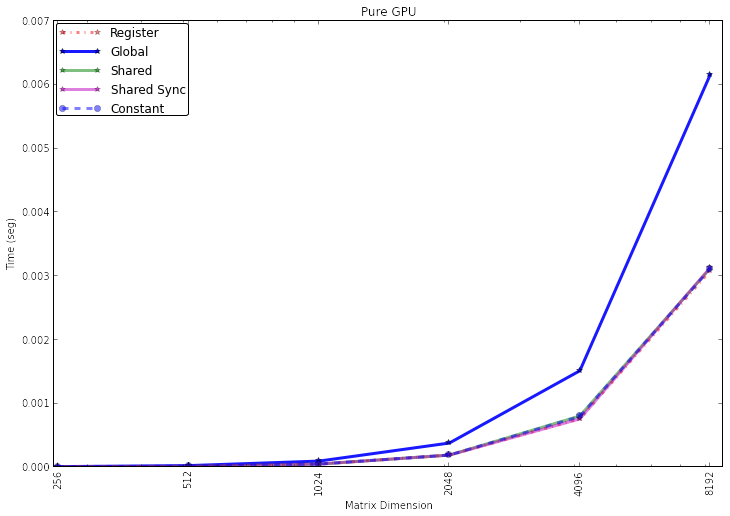

In [16]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.semilogx([2**i for i in range(8,14)],timeReg,'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeGlo,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],timeSha,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeShaSy,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeCons,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.title('Pure GPU')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')

([<matplotlib.axis.XTick at 0x7f66e4029510>,
 <a list of 6 Text xticklabel objects>)

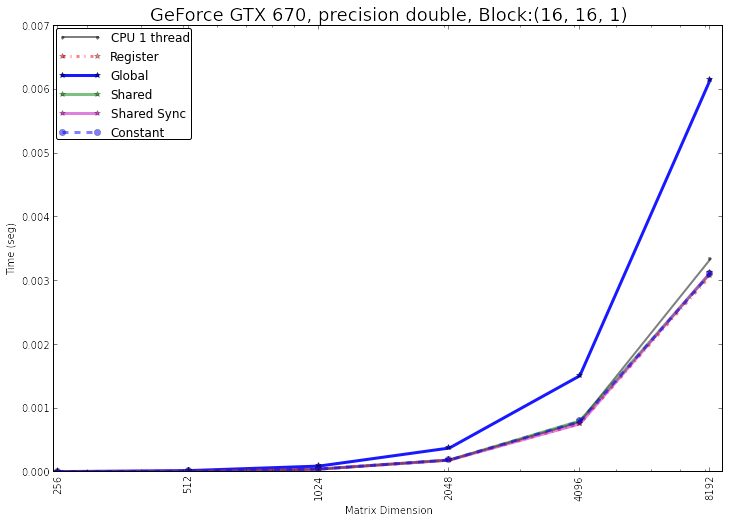

In [17]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
plt.semilogx([2**i for i in range(8,14)],timeCPU,'.-',color=(0,0,0),label='CPU 1 thread',linewidth=2.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeReg,'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeGlo,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],timeSha,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeShaSy,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeCons,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')


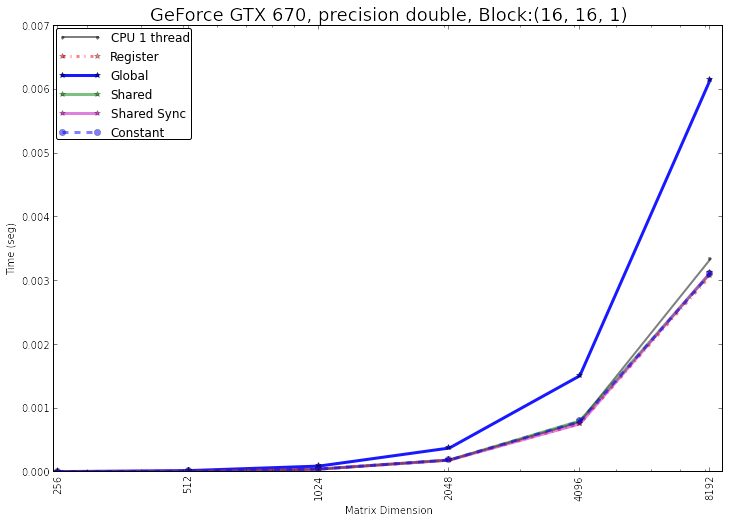

In [49]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtoAAAIJCAYAAACbRJqyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYFMf/B/D33nF0kKN3kCbFGlFEURHsDUGDigUVa6yJBUsMlsQWNd9gxYYVbL/YwSgqisZGoliwISAd6UqHu/v9QQ6PC+AhnCh8Xs8zj7e7Mzuf3VuPubnZWUYgEIAQQgghhBDSsFiNHQAhhBBCCCFNETW0CSGEEEIIkQJqaBNCCCGEECIF1NAmhBBCCCFECqihTQghhBBCiBRQQ5sQQgghhBApoIY2IYR8gSZMmLCfxWLx61ouPj7elMVi8VeuXOknjbjqa8WKFStYLBY/ISHBWNp1hYeHO7NYLP6BAwe8Jcn/qef8c/lc8Tk7O4e3bNkyrr77efv2rXaLFi3y9u7d69MQcZEK7u7up1xcXK42dhxEMtTQJlJXXFwsv3379u9cXFyuamtrv5WVlS3lcrk5nTt3vrd48eJ1L168aPWp+xb+Ia0p3bt3r3NDHktjiIqKajdlypTdVlZWL5WVlfMVFBSKTE1N44cPH/5/hw8fHlteXi7zsfMgmszMzGIBwMvLK4jNZvOuXr3qIl5nUVGRQqtWrV5oampmvn37VluSOLOzs9UXLFiw0cLCIkZBQaFIW1v7rYuLy9WbN286ieb7WHxr1qxZKpqfz+ezfvvtt++tra2fKygoFBkbGycsWLBgY2FhoWJ9zuuXjmEYAcMwn/ygg/qUbWrqci4+53kzNTWNF7322Ww2T09PL9XZ2Tn82LFjIxszvoao58cff/xZR0cnfeLEiYGi6wMCAqaNGTPmiLW19XM2m82T5MvD7du3Hd3c3M5oaWllKCgoFJmZmcV6eXkFlZWVcT41vhcvXrRasGDBRhcXl6tqamq5knxBLSwsVFy1atVPdnZ2TxUVFQs1NDSyunbt+tfp06eHfWocQN3OycqVK/2uX7/e89y5c0PqUyf5PGQaOwDStMXGxpoNHjz4/PPnz62dnZ3Df/jhh816enqp+fn5yg8ePOiwb9++SRs3blyQmJhopKenl/qp9Xh5eQUNHDgwRHy9ubn56/odQeNas2bN0uXLl6/W0NDIGjly5LHWrVs/kZWVLU1MTDQKCwvrPX78+IM3b950WrVq1U+HDx8eK1o2ICBgWkRERPf//e9/8zQ1NTOF65WVlfMBYNu2bTPDw8OdfXx89j5+/LiNcD0ALF68eN2rV68sjx49OkpbW/vtx+J88+aNibOzc3hhYaGij4/PXisrq5e5ublqjx8/bpOSkqIvmlc8TgAQCATMihUrVsTGxpoNHTr0rOi277///rctW7bM9vDw+GPhwoW/RkdH2/r7+8958OBBh7CwsN5NtUG5e/fuKQEBAdPqWs7U1DS+uLhYns1m86QRV1MnEAiYz1mfkZFR4tq1a5cAAI/HYyclJRkeOHDAe/To0cGpqal68+bN+19jxvepkpKSDAMDAydu3rz5B/FG47p16xZnZ2erd+jQ4UFhYaFicnKyQW37CgwMnDh58uQ9jo6Ot5cuXbpGTU0tNzk52eDmzZtO5eXlMhwOp+xTYrx9+7bjb7/99r2FhUWMvb195NWrV11q+zzJycnhurq6XomJibGYNGnSvnbt2kUVFBQoPXv2zKa+v9DU5Zy0bdv2kbOzc/jq1auXDxky5Fx96iWfgUAgoERJKqmwsFDB2tr6mZycXPHp06fdqstTXFwst27dOt+UlBS9T6nj2rVrzgzD8Ddt2vSDNI/l3bt3Kp/7/AUGBk5gGIbfp0+fSzXV//Dhw3bbt2+fUd02b2/v/QzD8N+8eWNcUx1nz54dwjAMf+rUqQHi59TT0/OYpLE6OTlFGBsbv0lLS9P5lGNNTEw0ZLFYvM6dO98VXf/kyRM7hmH4I0aMOCG6fsuWLbMYhuEHBQWN/tzvS2NfF1978vPzW/Gx67KhkvBaPnDgwHhJ8gv/z3yuc2FiYhLfpk2bR+Lrs7Ky1GVlZUvat2//oDHi69mzZ3jLli1j67OPH3/8cTWHwynNyMjQFN8m+t4PGjToPIvF4tW0n6dPn9rKysqWTJkyZVdDH2d2djY3Ly9PVSAQIDIysiPDMPyVK1f+VFP+sWPHHmrRokXus2fPrBs6lrqcE4Hgw9+Hf/75p4O0rwdK9Us0dIRIzZ49eya/ePGi1cKFC391c3M7U10eOTm5El9f3/Xivdl5eXktfH1911tYWMTIy8sXa2trv/Xy8gqKi4tr+anx3Lhxo0efPn0uq6mp5SoqKhZ27Njx73379k0SzyccnxgXF9dyxIgRJ9XV1bNbtGiRJ9yelpamO2fOHH8zM7NYeXn5Yh0dnfS+ffteCgsL6y26n1evXlmOGzfukJ6eXqqcnFxJy5Yt4xYtWrRBkiEPpaWlskuXLl2jqqr67vjx454qKirvq8vXrl27qBkzZuz4lPMBAEOGDDk3bty4Q7t3755y6dKlvu/fv1eZOHFioI6OTvqOHTtmSLKPGzdu9Lh161a3RYsWbdDR0UkvKyvj1HVYR2Bg4ESBQMBMnjx5j+j64ODg0QAg3qs3ZcqU3YqKioXV9Y5Lav/+/RNYLBb/ypUrritWrFhhYmLyRl5evrhdu3ZR1f1sb2pqGt+rV69rDx486NCvX78/1dTUctu1axcl3F6X91uSa6i68biJiYlGkyZN2ieMVUdHJ71bt263Dh48OF6Yp6Yx2uXl5TLr16/3tbW1jVZQUCjS1NTM9PDw+OPJkyetRfOJlj9//vzgTp063VdQUCjS19dPWbRo0QYej8eW5Pzy+XzW2rVrl7Rs2TJOQUGhqE2bNo+DgoK8asr/6NGjtu7u7qc0NDSyFBQUiuzs7J7++uuvC/l8fpW/UzWNH65tbLpAIGC2bNky28rK6qWCgkJRq1atXmzdunWWJMcBAKmpqXozZszYYWxsnCAnJ1diYGCQPG3atICMjAwtSfdRF2pqarlycnIlsrKypZLkl/TcAZJ/fonLysrScHR0vK2mppZ77dq1XsL1r1+/Nq9u+N+JEye+7dSp033RX9OEjI2NEyQ5LgDYuHHjAoZhBBs2bFgEAAUFBUrl5eUN8ms8l8vNUVVVfQd8/JeC+Ph40+Dg4NFTpkzZbW1t/ZzH47Hz8/OVGyIOoG7nBAD69+9/EQCOHz/u2VAxEOmgoSNEak6ePDmCYRiBeOPpY/Ly8lp07dr1r8TERCMfH5+9dnZ2T1NSUvS3b9/+nYODw93IyEh78Q+lgoICpczMTE3RdfLy8sXC4RDnzp0b4u7ufkpfXz9lwYIFG1VUVN4HBwePnjx58p7Y2Fizn3/++UdhOYZhBPn5+co9e/a87uTkdHPt2rVLhOOU4+PjTbt163br7du32t7e3gfs7e0j8/Pzle/cudPlypUrrr179w4DgL///ruji4vLVXV19ewZM2bsMDAwSH748GF7f3//Obdu3ep2/fr1njIyMuU1nYNbt251S0tL0/X29j6gpqaWW5fzV1f+/v5zrl696jJ58uQ93bt3j3jz5o3JH3/84aGurp4tSfmQkJCBQMVP4EOGDDl38eLF/jwej21pafnqp59+WjVmzJgjtZUXCARMYGDgRGVl5fzRo0cHi267f/9+JzabzevcufM90fVycnIl7dq1i7p//36nuh6vOF9f3/WFhYWKs2bN2iqMZfTo0cHFxcXy3t7eB4T5GIYRJCQkGLu6ul7x9PQ8/u23354Q/qGty/st6TUkrFP4ury8XKZPnz6XU1JS9GfOnLnNysrqZV5eXouoqKh2N2/edBo/fvxB0eMS/wl8zJgxR06cOPFt3759L82cOXNbamqq3rZt22Y6OjrejoiI6N6+ffuHovlDQkIGbt++/bsZM2bsmDx58p7Tp08P27hx4wIul5uzZMmStR87rz/88MNmf3//OT179rw+f/78Tenp6TozZ87cJrxHQFRkZKR9z549r8vJyZXMnDlzm66ubtrZs2eH+vr6ro+Kimon/oWqtp/3q9u2ZcuW2WlpabrTp0/fqaKi8j4oKMhrzpw5/tnZ2eo//fTTqtqOIyEhwdjR0fF2eXm5jI+Pz15zc/PXr169styxY8eMa9eu9YqMjLQXNtY+RXl5uUxWVpaGQCBgeDweOzU1Ve/333+fW1BQoDRt2rSAj5Wvy7mry7UnKi4urmX//v0vFhQUKN24caNH27ZtHwm3ubq6XklISDAWbdSnp6frvHz50mru3Lm/f+p5EQoNDR1gbW39/Nq1a70WLlz4a2xsrBmHwynr3bt32O+//z7XwsIipr51SOLixYv9+Xw+y8bG5tm4ceMOnThx4tvS0lJZAwOD5Pnz528S7wyQNl1d3TRTU9P48PBw589ZL/kEjd2lTqnpJnV19Sw1NbUc8fU8Ho+VkZGhKZqKiorkhdvnzJnzu6KiYsGjR4/aiJZ78+aNsaqqat6ECRMCheuEPw1Xl0aPHh0kEAhQXl7ONjY2fsPlcrNTU1N1hWVLS0s53bp1u8lms8tfvXplIVzfs2fPcIZh+MuXL18lHvuAAQNCWCwW79KlS33Et/H5fEb4um3btlE2NjbR+fn5SqJ5Tp06NYxhGP7+/fu9azt3/v7+sxmG4f/vf/+bK77t3bt3KqLnLjMzU6O6fUgydESYQkND+wvP29ixYw/V5X0eNmzYKYZh+Nra2ulOTk4RQUFBowMDAye0bt36McMw/MDAwAm1lQ8LC3NlGIY/adKkveLbWrdu/VhXVze1unLffvvtcYZh+GVlZTKfcn0Kf3o1NTWNEx0CkpeXp2piYhKvrq6eJXpdmpiYxDMMw9+7d+8k8X3V5f2W9BoSHyYQFRXVlmEY/q+//rqgtuOKi4szFf8J/NKlS30YhuGPGjUqWDRvVFRUWxkZmbLu3bvfEC+vrKz8Xvzaad269WM9Pb2Uj53b58+ft2IYht+7d+/Losf0zz//dGAYhs9isXii++7atestDodT+vjx49ai+/H09DzGMAz/ypUrLsJ1NQ1rqO64hZ8PqqqqecnJyfrC9aWlpZzOnTvf5XA4pUlJSQY1nXOBQIChQ4ee0dHRSRMtLxBUDDWQkZEpW7Fihd+nXH+i15R4UlBQKNy9e/dk8fzVxVeXcyfptSd6jv/5558Ourq6qTY2NtHVfZaYmprGiQ9zuHr1ai+GYfhbtmyZ9bFzUNswidzc3BYMw/A1NDQyORxO6Q8//LDp9OnTbitXrvxJXl6+SEdHJ+1Th6uJp/v379vXNnRk3rx5vwk/5+zs7J7s37/f+8iRI17du3e/wTAM38/Pb0VDxPGxcyKaXF1dw1RUVN41VL2UpJMaPQBKTTfJyMiUGRsbvxFf//jx49bif1g2btw4XyCo+LDX0NDI7N+/f2hmZqaGeIO8T58+l/T19ZOF+xL+IZ0+ffqOK1euuIimp0+f2goEAty9e7czwzD8+fPnbxSP5cyZM0NF6xcIKv7IsFgsnnDsnjBlZWWpMwzDHzhw4IXajvvRo0dtGIbhr1q1arl4/G/fvtVSUlLK9/LyOlLbPn7++edlDMPw9+3bN1F82/Dhw0+KnjtlZeX31e2jLg3tO3fuOLBYLB7DMPzg4OBRdXmfXV1dwxiG4VtYWLwSbfTm5OSocbncbD09vRTRP+LiadSoUcEMw/Bv3brVVXybmZnZaxMTk/jqyo0bN+4gwzB88fdJ0iRsaK9fv36R+La1a9cuZhiGHxoa2l+4zsTEJF5TUzND/Fjq8n5Leg2Jvn/C5fj4eBOGYfgDBgwIefv2rVZN5aprcM6YMWM7wzB88caYQCCAu7v7HwzD8IVf2ITlq/vCNWvWrC0Mw/ALCgoUa4t9/fr1ixiG4YeEhAwQ39avX7+Lotdlenq6NsMw/OHDh58Uzyv8cjFr1qwtwnWf0tCeMWPGdvH8wcHBoxiG4e/YsWN6Tec8Nze3BYvF4k2ZMmWX+HubkZGh2apVq+ddu3a99SnXn/CaMjMzey38zAoLC3M9cODA+F69el1ls9nl4l9SxeOry7mry7XXs2fPcFNT07jLly/3VlFRede1a9db2dnZXEmP69ixY54Mw/CPHDni9bG8tTUqExMTDYWfc+IdH/v37/dmGIbv6+u77lPPv2j6WEPbx8dnD8MwfC6Xmy16LsrKymQsLS1fKigoFObk5Kg1RCySNrSFX6aKi4vlGqJeStJJNEabSI2qquq7d+/eqYqvNzMziw0LC+sdFhbWe+PGjQuADz/3ZmRkaGVnZ6v/+eef/bS0tDK0tbXfiqawsLDe1U03Z2lp+crFxeWqaLK1tY0GKn72BAA7O7un4uXE8whpaWlliP8cHBMTYwEAHTp0eFDbcT979swGAPz8/FaKx6+jo5NeWFio+LEp84R1V3f+VqxYsSIsLKz35cuX+7Rt2/ZRfWfdEA6R4HK5OUZGRok//PDD5tzcXDVJyysoKBQBwOjRo4NFh8OoqanlDhky5FxaWpruy5cvraorm52drX7q1Cl3GxubZ127dv1LfLuiomJhSUmJXE1xMwwjUFRULJQ01urY2Ng8q2md+HVhbm7+Wvx81+X9lvQaqo6JicmbZcuW/XLp0qW+enp6qfb29pG+vr7rIyMj7T9WNi4uriWbzeZVd6w1/R+oboiHhoZGFlAxXre2+mJjY80AwNra+rn4NvEYavv/aW1t/ZxhGEF97s2ork7RdbXt+8WLF60EAgGzZ8+eyeLvrba29tuXL19aSTr9ZU2UlJQKhJ9Zrq6uV8aPH3/w8uXLfWxtbaNnz569JTs7W72msnU5d3W99tLT03UGDRp0wcLCIubKlSuuXC43R9JjEv4fEdRzhhThZwvDMIIJEybsF902ZsyYIywWi3/9+vWe9amjrrEMHjz4vOi5kJGRKffy8goqLi6Wv3v3rsPniEVIIBAwTD2nASXSR2O0idS0bt36SURERPf4+HhTU1PTeOF6RUXFQuFk++I3ewk/mPv06XPZ19d3/WcNWER9Gm/CY1iwYMFG4Q0r4j72R6tNmzaPAeDBgwcdxLe1bt36ifB1Q4zfXrp06ZqXL19aBQUFeWlqamb27dv30pw5c/xFb7CrjaGhYRJQMWZQfJvwJtecnBxudWWPHDkyprS0VNbHx2dvddv19fVTnj9/bl1WVsYRn8IrOTnZQFNTM7O2se4NrbrroiHeb0mtXr16+aRJk/ZduHBhUERERPc9e/ZM/vXXXxcuWrRow7p16xY3RB1CtU0PWN8GVH3U1KhoqBvkRAmPc9y4cYdEx+uLEjbAGhKbzea5uLhc9ff3n3P37l2HAQMGhDZ0HR+jrq6e3bFjx7/Pnz8/+PDhw2Prcq+NlpZWBlDxRbq+MSgoKBQVFxfLi3++yMjIlGtqambW9NnS0Gr7nBOu+1yxCGVnZ6srKyvnS3rTLGkc1NAmUvPtt9+eEDYGRG82rI2WllaGmppabl5eXouGevKVcC5t8dkVACA6OtoWqL73TpyFhUUMwzCC6hq/oqysrF4CFV8iPvUYunXrdktXVzft1KlT7ps3b/5B0hsT6yoiIqL777//Pnf48OH/N2rUqKMAMHXq1F27du2a+u23356QZI5WBweHuwEBAdMSExONxLclJSUZAkBNc3Hv3bvXR1ZWtlT8Rj6hzp0737t8+XKfu3fvOjg5Od0Uri8uLpZ/+PBhe2dn53AJD7VG0dHRtuLHWZfroi7vt6TXUG1atmwZN2vWrK2zZs3aWlJSItevX78/N2zYsGjBggUbq5vhAag4Dh6Px46OjrYVfokTio6OtmUYRtAQTwIUEv6fe/bsmY34foXnVvR4gOr/fz5//txaIBAwou+Durp69j///PONeF5hL3p1xOsUXVfbeyx8v0pKSuQ+95P4hA9iqW1mi7qcu7pee7KysqV//PGHh6en5/Fp06YFlJWVcSSd4UjYw/7q1StLSfLXhGEYQadOne7fuHGjR2JiolGrVq1eCLeVlJTIZWRkaAn//0mbg4PDXaBi5h/xbR/7nJOWmJgYC9GOF/KFauyxK5SabioqKpK3sbGJlpWVLTl16tSw6vIIb5oRnQdbOA705MmTw6srIzo+VZJ5tHk8HsvExCSey+Vmi944U1paynFycopgs9nlMTEx5sL1tc0hO2jQoPMMw/DDwsJcazv2Nm3aPGrRokVubGxsS/FtZWVlMpKMdxSOIe7du/flmsYh9+jR43pNN8N8bIx2fn6+krm5eYy2tna66Fy379+/VzYxMYnX09NLkWTMYU5OjpqqqmqeoaFhoujNgCkpKXpKSkr51tbWz6orJxwTKT5Htmh6/PhxaxaLxRMfgyq8WVSSMaAfO78mJibxouc3Nze3hbGx8Zvqbobs1avX1fq+35JeQ97e3vtFx2nm5eWplpaWcsTzTZs2bSfDMPyXL19aCgTVj1W+fPlyb9EbhEXPL5vNLu/Ro8d14brqyguTpHNgP3/+vBWLxeK5urqG8Xg8lnD933///Q2LxeKJ3wzZrVu3mxwOp/TJkyd2wnV8Pp8Rjt+/evVqL+H6JUuWrGEYhn/v3r1OwnU8Ho/Vv3//0JrGaKuoqLwTvemxpKREtlOnTvequxlSfGzs4MGDz3E4nNI7d+44iB8nn89nqpsnWtJU0zzaRUVF8mZmZq9ZLBZP9LOpuvjqcu4kvfZEPwPLy8vZwrHAv//++xzxvDExMebPnz9vJb6+devWj+3t7e9/7Bx8bDzynj17fBiG4c+dO/d/ouuFnwFr165d/KnnXzR9bIw2j8djmZqaxikpKeWL3hibn5+vZGRklKCurp5VWFio0BCxSDJGOzU1VZdhGP6SJUvWNESdlKSXqEebSI28vHzxhQsXBg0ePPi8h4fHH87OzuF9+vS5rKurm/bu3TvV58+fWx87dmykjIxMuZGRUaKw3C+//LLs1q1b3Tw9PY97enoed3BwuCsrK1v65s0bk5CQkIH29vaRgYGBEyWNg8Vi8bdu3TrL3d39VKdOne5PnTp1l7Kycv6xY8dG3r1712HZsmW/iD9BUlDDT+Nbt26d1bVr178GDBgQ6u3tfeCbb775p6ioSOHu3bsOLVu2jBP+fH/o0KFxLi4uV9u2bfto0qRJ+2xtbaMLCwsVY2JiLE6dOuW+bt26xTX14gpNmDBhf0pKiv7y5ctXm5ubvx45cuQxOzu7pxwOpyw1NVXv0qVLfW/dutVNvIdSUosWLdoQGxtrdvz4cU/xJ0fu2bNnsqRDSNTU1HI3bty4YNq0aQFdunS5M2nSpH0lJSVyO3bsmFFeXi6zZcuW2dWV27t3rw8A1PaTdOvWrZ/MnDlz29atW2cNHz78/wYMGBD67Nkzmy1btsx2dnYO9/LyChLNv3///gmTJk3a5+fnt9LPz2+lJOdBS0srw8HB4e7EiRMDBf9O75eUlGS4Z8+eyfLy8sWS7KMu77ek1xBQ9Tq8evWqy9SpU3eNGDHipJWV1UtlZeX8v//+u+PevXt9unTpcsfS0vJVTfH17t07zNPT8/jRo0dH5eTkcAcNGnQhLS1Nd9u2bTMVFRUL/f3950hynJJq1arVC+H75uLictXDw+OPt2/fam/btm1m+/btH4r3qv7+++9ze/bseb179+4RM2fO3Kajo5N+/vz5wZcuXeo7ZsyYI7169bomzDt16tRdmzZtmu/u7n5q7ty5v3M4nLKTJ0+OqG1+bysrq5cODg53p0+fvlNZWTk/KCjIKzIy0v6nn35aZWBgkCyaV/z//o4dO2Y4OTnd7NGjx43x48cfbN++/UM+n8+KjY01O3v27FBvb+8DolMEslgsvomJyRtJx5Xn5uaqHTlyZIxAIGAEAgGTkpKif/jw4bFxcXEtp06duutjn011OXefcu2x2WxecHDwaA6HUzZv3rz/lZeXy/zwww+bhfmqm94PqPhFc/Xq1cvT0tJ0xYdbnDt3bkhUVFQ7oKJXViAQML/88ssygUDAcLncnJkzZ24T5p04cWLgwYMHx/v7+8/JzMzUdHJyuvn48eM2u3btmtq6desnc+bM8Rfdt7Ozc/iNGzd6xMfHm35sbup3796pCq994RNsr1+/3lP4C6ybm9sZ4ecri8Xib9++/buhQ4eedXR0vP3dd99t53A4ZYGBgROTk5MN9u7d6yM6jCg8PNzZxcXlqre39wFJ/l7V5ZwAH6ZV/fbbb098bN+kkTV2S59S009FRUXy27Zt+65Xr15XNTU1MzgcTqmamlpOp06d7vn6+q4T9sSJpsLCQoXVq1f/2KZNm0cKCgqFKioq72xtbZ9OnTo1QLQnqy5Phrx+/XqPPn36XFJVVc2Tl5cv+uabb/6ublYPZ2fna7U9FS05OVl/+vTpO4yNjd/IysqW6OjopPXr1++iaM+RQFAxHeH06dN3mJqaxsnKypZoaGhk2tvb31+6dOkvor1oH0sPHz5sN3ny5N2WlpYvFRUVC+Tl5YtMTEziPTw8/u/IkSNe5eXl7OrKTZgwIVC851CYwsLCXFksFm/kyJFHa6p32rRpO1ksFu/cuXODJYnzjz/+cO/SpcttJSWlfBUVlXf9+vW7+NdffzlWl7ewsFBBTU0tp6YZRUQTj8djbdq06YdWrVo9l5OTKzY0NEycP3/+xupmvhD2cu3Zs8fnY/sV9mhfuXLFxc/Pb4WxsfEbOTm54rZt20ZVN/OKqalpXE092nV9vyW5hoTvn3A5Li7OdPr06TtsbGyiVVVV85SUlPJtbW2f+vn5rRCdnrCmHuny8nL2+vXrF9nY2ETLyckVa2hoZLq7u/8h2hNaW3mBQIAVK1b41XRNiSc+n8/88ssvS01MTOLl5OSK27Rp8ygoKGh0TfuIiopqO2zYsFPq6upZcnJyxba2tk9//fXXBdXNWBMSEjKgffv2D+Tk5IoNDAySFi9evPbFixdW1fVos1gs3oEDB8b7+/vPtrS0fCknJ1dsZWX1wt/ff3ZN/2fE12dmZmosXLhwg5WV1Qt5efkiNTW1nLZt20bNmzfvN9GnBL57906FYRi+k5NThCT/Z4QpehXsAAAgAElEQVRT44nOIqSkpJTfuXPnuzt37pwmaXx1OXeSXHvVfQby+XxmwoQJgQzD8NetW+crfgzi9aSkpOhxOJzS6j6bhfsRTvUoeg6q++wtKChQXLx48Vrh/y1DQ8PE2bNn++fm5rYQz/vNN9/8rays/F6S2YiE13p1sQivG/Ey169f7+Hi4nJFRUXlnaKiYoGTk1PE+fPnB4nnEz5198cff1wtybVQ13Pi7Ox8TfxJupS+zNToAVCiRIlSQyV3d/c/rKysXtT05UM0CRva169f79HYcVNqGkk4XWh4eHjPxo7lS0jTp0/fYWZm9vpT57qva8rOzuay2ezy+sxt3lDp+++/36yhoZHZUFP+iaYHDx60r0snCKXGTVKd3u/ixYv9ra2tn1taWr5av369b3V55syZ429pafmqXbt2UaI/J9ZUdtSoUUc7dOjwoEOHDg9atmwZ9ynTZBFCmp7y8nKZa9eu9Vq3bt3i2mbMIERaLl261HfIkCHnevbseb2xY/kSrFq16qesrCyN/fv3T/gc9YWFhfXW0dFJX7Ro0YbPUV9tLl261HfZsmW/SOPJvitXrvRzdnYOHzx48PmG3jeRAmm14MvLy9nm5uYxcXFxpqWlpZx27do9jI6OthHNc+HChYEDBgwIEQgqHpjh4OBwR9KyAoEA8+fP37h69eofG/vbCiVKlL6+RD3alChRokRJ2klqPdr37t3rbGFhEWNqahrP4XDKRo0adfTMmTNuonmEN5IAFVPn5ObmqqWlpelKUlYgEDDHjx/3HD16dLC0joEQ0rTRgx4IIYRIk9RmHUlOTjYQnUnC0NAwSfypSdXlSU5ONkhJSdH/WNmIiIjuOjo66eJ3ZAP0x5MQIjn6mZ8QQkh9CGp5iJfUerQlbezWFlxtgoODR4tP7SW238rk5+fXKD8XNFa9dFw1x9kYsTflOqVVj7Tj/1quYUrSfd/pOqjb+Woq6Uv52/A1nf+m+nesIT4TPkZqPdoGBgbJok9QSkxMNBI+wrSmPElJSYaGhoZJZWVlnNrKlpeXy5w6dcq9uqeDfUmcnZ0bOwSp+FqO60uJszHi+Fx1SqueL+W9I00LXVd101TP19dyXF9SnE3179hnOS5pfUsoKyuTMTMzex0XF2daUlIi+7GbIW/fvt1FeDPkx8qGhob2d3Z2vlbLtwuBUGJiosDU1FTAYrEEAChRErBYLIG9vb0gMTFRQJonPz+/xg6BfAHoOiBCdC0QgeDTrgMAAkEt7WGp9WjLyMiUb926dVa/fv3+5PF4bB8fn702NjbPAgICpgHAtGnTAgYOHBgSEhIy0MLCIkZJSalA+PSkmsoK933s2LGRkt4E6e7ujilTpmDBggWQlZWVzsGSr0ppaSk2btwId3d33L9/v7HDIY3gS+opIo2HrgMiRNcCAaRzHTACCcaXfG0YhhEIj4vNZqOoqIga2aSK0tJSKCgogMej6ZYJIYQQ8mkYhoGglvsNm3xD+98T0MgRkS8RXRuEEEIIqY+PNbSl+mRIQsRNmDABy5cvb5S64+PjwWKxwOfzG6V+QgghhDQv1NBuAoKCgmBvbw8VFRXo6+tj4MCBuHXrFgBgxYoV4HA4UFFRAZfLRbdu3XDnzp3KbePGjfvP/lgsFmJjY6uta+vWrbC3t4e8vDwmTpxYa1z79+9H9+7dq6xjGAYM80kzOhJCCCGEfFWoof2V27x5M77//nv8+OOPePv2LRITEzFz5kycO3euMs/o0aPx/v17ZGRkwMnJCR4eHp9cn4GBAZYvX45JkyY1RPi1Ki8vl3odhBBCCCHSQg3tr1heXh78/Pywfft2DBs2DAoKCmCz2Rg0aBDWrVtXmU84DllGRgbjx49HWloasrKyPqlOd3d3uLm5QUNDo9Z8z549w4wZM3D79m2oqKhAXV29clt2djYGDx4MVVVVdOnSpUrvOYvFwvbt22FpaYlWrVoBAM6fP4/27dtX9sg/fvy4Mv+6detgYWEBVVVV2NnZ4fTp05Xb+Hw+FixYAC0tLZibm+PChQufdMyEEEIIIZ9CatP7fclOnDiBvXv3QkZGBu3bt4eMTOOdhqdPn+L9+/eQkZHByZMnIS8vL3HZ27dvo7i4GO7u7hLlLykpwf79+2FsbPzRhvLHfOwmQhsbG+zcuRN79uxBRERElXJHjx7FxYsX0aFDB3h7e2PZsmUIDv4wW+OZM2dw//59KCgo4MGDB/Dx8cH58+dhb2+PQ4cOYejQoXj58iU4HA4sLCxw8+ZN6Orq4vjx4xg7dixev34NHR0d7Nq1CxcuXMDDhw+hqKgIDw8PGrZCCCGEkM+mWfZoJycno7i4GDk5OXj69GmjxvL+/fvKWI4fP16nsllZWdDU1ASLVfvbePz4cXC5XBgbG+PBgwc4depUfUIGAIkarNU1xhmGgYeHB+zt7cFmszFmzBg8fPiwSp4lS5ZATU0NcnJy2LVrF6ZNm4ZOnTqBYRiMHz8ecnJyuH37NgBgxIgR0NXVBQB4enrC0tIS9+7dA1Bx3N9//z0MDAzA5XKxdOlSmmWEEEIIIZ9Ns+zRlpeXh4ODA7hcLubNm1enXuSGtnPnTsTFxYHL5cLT07NOZTU0NJCZmQk+n19rY3vkyJE4ePDgf9ZzOByUlZVVWSdc5nA4tdZdnwarjo5O5WsFBQXk5+dX2W5kZFT5+s2bNzh48CC2bNlSJcbU1FQAwMGDB/Hbb78hPj4eAJCfn4/MzEwAQGpqapV9GRsbf3LMhBBCCCF11Sx7tCdMmAA7O7tGb2TXNxZHR0fIycnV2kNd21zRxsbGlQ1Uobi4OMjIyMDAwKDWuiXp0f7UYRqi5YyNjbFs2TLk5ORUpvz8fIwcORJv3rzB1KlTsW3bNmRnZyMnJwetW7euPF49PT0kJCRU7kv0NSGEEEKItDXLhra8vDzGjx/f6I3s+sbSokULrFq1CjNnzsSZM2dQWFiIsrIyhIaGwtfXF0DtPc/9+/fH8+fPcfjwYZSVlSE7OxtLly7FiBEjauwh5/F4KC4uRnl5OXg8HkpKSmp8uqKuri6SkpKq9JrXtSd8ypQp2LlzJ+7duweBQICCggJcuHAB+fn5KCgoAMMw0NTUBJ/PR2BgIJ48eVJZ1tPTE/7+/khOTkZOTk6VG0QJIYQQQqStWTa0m5IffvgBmzdvxs8//wxtbW0YGxtj+/btlTdI1jZvtZaWFkJDQxEQEAAdHR20adMG6urq2LFjR431rV69GoqKili/fj0OHz4MBQUF/PLLL9XmdXFxgZ2dHXR1daGtrV1jPKLL4ts6duyI3bt3Y9asWVBXV4elpWXlMBhbW1vMnz8fjo6O0NXVxZMnT+Dk5FRZdsqUKejXrx/atWsHe3t7DB8+nG6GJIQQQshnQ49gJ80WXRuEEEIIqQ96BDshhBBCCCGNgBrahBBCCCGESAE1tAkhhBBCCJECamgTQgghhBAiBdTQJoQQQgghRAqooU0IIYQQQogUUEObEEIIIYQQKaCGNiGEEEIIIVJADW1SRUJCAlRUVOhBLoQQQggh9UQN7a+YqakpFBUVoaKiAl1dXYwbNw7v3r2r1z6NjY3x/v37jz6qfP/+/ejevXu96iKEEEIIacqaZUNbIBDg1sWLX0SvbX1iYRgG58+fx/v37xEVFYXHjx/j559/lkKUDa+8vLyxQyCEEEIIkapm2dB+HR2N96dO4XV0dGOH0mCx6OjooG/fvnj69CkA4M6dO+jatSu4XC7at2+P69evV+aNi4tDjx49oKqqij59+mDmzJkYN24cACA+Ph4sFgt8Ph9ARc+1ubk5VFVVYWZmhqCgIDx//hzTp0/H7du3oaKiAnV1dQBASUkJFixYABMTE+jq6mLGjBkoLi4GAISHh8PQ0BAbNmyAnp4efHx86nW8hBBCCCFfOpnGDuBzenT/Pp6EhkKntBT9iotxdcYM3GOz0XrkSLSdPr1q5vDwin+dnf+7XnRbddslKPdISelDLLq6uBocjHuysmg9YADaduok8TEJe8KTkpJw8eJFjBgxAsnJyRg8eDAOHz6M/v37IywsDMOHD8eLFy+goaEBLy8vdO/eHVevXsXdu3cxcOBAuLm5/WffBQUFmDt3LiIjI2FpaYn09HRkZWXB2toaAQEB2LNnDyIiIirzL168GHFxcYiKioKMjAy8vLywatUqrFmzBgCQnp6OnJwcJCQkgMfjSXyMhBBCCCFfo2bVo93G3h6dPDwgKCkBwzAQ8HjobGODNq1aNX4sJSXoPHw42tjbS7wPgUCAYcOGQVVVFcbGxjA3N8eyZctw+PBhDBw4EP379wcA9O7dG/b29rhw4QISEhIQGRmJVatWQUZGBt26dcPQoUNrHLrCYrHw+PFjFBUVQUdHB7a2tpV1i8eye/dubN68GWpqalBWVsaSJUtw9OjRKvtauXIlOBwO5OXl63rKCCGEEEK+Ks2qoc0wDBiGQfm7d/hTIEB5SUnl+kaP5d+bGOsSC8MwOHPmDN69e4fw8HBcvXoVf//9N968eYMTJ06Ay+VWplu3biEtLQ0pKSlQV1ev0tA1MjKqdv9KSko4duwYdu7cCX19fQwePBgvXryoNm9GRgYKCwvRsWPHyjoHDBiAzMzMyjxaWlqQlZWV+PgIIYQQQr5mzWroCADkZWTAYs4cmNva4nV0NN5lZgI9e/43o/jQD9H1NW2rY7lqY/lEPXr0wOzZs+Hr64t+/fph3Lhx2LVr13/yvXnzBtnZ2SgqKoKCggKAiin9amrg9+3bF3379kVJSQmWLVuGKVOm4MaNG//Jr6mpCQUFBURHR0NPT6/afTXGFxpCCCGEkMbSrHq0AaCjszMs7OzAMAws7OzwTXWN7K80lnnz5uHevXtwcnLCuXPncOnSJfB4PBQXFyM8PBzJyckwMTGBvb09VqxYgbKyMty+fRvnz5+vthH89u1bnDlzBgUFBeBwOFBSUgKbzQZQcfNlUlISysrKAFQMC5kyZQrmzZuHjIwMAEBycjIuXbpUr2MihBBCCPlaNbuGdlOmqakJb29vbN68GWfPnsWaNWugra0NY2NjbNq0qXImkSNHjuD27dvQ0NDA8uXLMXLkyCpDOoSNbj6fj99++w0GBgbQ0NBAREQEduzYAQBwdXWFnZ0ddHV1oa2tDQBYv349LCws0KVLF7Ro0QJ9+vTBy5cv/7NfQgghhJDmgPkS5pJuaAzDCITHxTDMFzFf9pds5MiRsLW1hZ+fX2OH8lnRtUEIIYSQ+vi3LVFjTyL1aDdDkZGReP36Nfh8PkJDQ3H27FkMGzasscMihBBCCGlSmt3NkARIS0uDh4cHsrKyYGRkhJ07d6Jdu3aNHRYhhBBCSJNCQ0dIs0XXBiGEEELqg4aOEEIIIYQQ0giooU0IIYQQQogUUEObEEIIIYQQKaCGNiGEEEIIIVJADW1CCCGEEEKkgBraTdyECROwfPlyifKyWCzExsZ+Uj2mpqa4cuXKJ5UlhBBCCGmKqKHdBBw9ehQODg5QVlaGjo4OunTpUvmodIZhPsujzz9XPYQQQgghX4tm2dAWCAT45ZftX8QcyvWNZdOmTZg3bx58fX2Rnp6O9PR07Ny5E3/99RdKS0sr6yCEEEIIIZ9Xs2xoX7gQju3b0xEScr2xQ6lXLHl5efDz88OOHTvg4eEBJSUlAED79u1x6NAhyMrK/qfM7t27YWlpCQ0NDbi5uSE1NVUsngswNzeHlpYWFi1aVNlIf/36NVxcXKCpqQktLS2MHTsWeXl5n3DEhBBCCCHNQ7N6BPuhQ/+H7dvPIDLSFjzeCgwbth4Msw+Kim5QVBz+WWMpLPw/FBaegUDwIRZ7+3347js3jBsnWSy3b99GSUkJ3NzcJMp/9epVLF26FJcvX4atrS0WLFiAUaNG4fr1D43806dP4++//8b79+/Ru3dvtGrVCj4+PgCAZcuWoUePHsjLy8Pw4cOxYsUK/Pbbb3U/eEIIIYSQZqBZ9WiPHeuBpUsnAOD/O56YD2XliVBQ8PjssSgoeEBZuWosy5ZNxNixkseSmZkJTU1NsFgf3sauXbuCy+VCUVERERERAFA5dvrIkSPw8fFB+/btISsri7Vr1+L27dtISEioLO/r6ws1NTUYGRlh3rx5CA4OBgCYm5vD1dUVHA4Hmpqa+P7776s00AkhhBBCSFXNqqEtvGGPzy8Bm70CfH4xgMa5ia+izqqx1PWGQg0NDWRmZoLP51eu++uvv5CTkwMNDY0q6wEgNTUVJiYmlctKSkrQ0NBAcnJy5TojI6PK18bGxkhJSQEApKenY9SoUTA0NESLFi0wbtw4ZGVl1fWwCSGEEEK+ONK6f69ZDR0BgNjYFJw92wsDB/ZESMh1xMamYPbsxonF3z8F5uZVY6kLR0dHyMnJ4fTp0/Dw+HhPuL6+PuLj4yuXCwoKkJWVBQMDg8p1CQkJsLGxqXwt3LZ06VKw2Ww8efIEampqOH36NGY31okjhBBCCGlAFy6Ew98/HW3aXMfQoc4Ntt9m19CeM2dM5etBg5wbLxDUPxY1NTX4+fnhu+++g0AgQN++faGkpIRHjx6hoKCgMp/w29no0aMxevRoeHl5wdraGkuXLkWXLl1gbGxcmXfjxo1wcHDA+/fv4e/vj/nz5wMA8vPz0aJFC6iqqiI5ORm//vrrJx41IYQQQsiXQXj/XmmpLbKzV2D06PXQ0dmHZcvc4ONT//v3mtXQkaZo4cKF2Lx5MzZs2ABdXV3o6upi+vTp2LBhA7p27QrgwxhtV1dXrF69GsOHD4e+vj7i4uJw9OjRKvtzc3NDx44d0aFDBwwePBiTJk0CAPj5+eGff/5BixYtMGTIEAwfPpzmzSaEEELIV014/15mJh98PoPSUj7KyyfCy6th7t9jmuIcywzDCITHxTAMzSNNqkXXBiGEEELOn7+GESPCwecz4PH4GD/eBYGBzhKV/bctUWPPY7MbOkIIIYQQQojQjRspUFTsBTm5nuDxrsPCom73zNWGGtqEEEIIIaTZKigYA3n5itcjRzpj2bKG2zeN0SaEEEIIIc1Saipw7tyH5alTG3b/1NAmhBBCCCHNUmAgUF5e8bpLF6BNm4bdv1Qb2hcvXuxvbW393NLS8tX69et9q8szZ84cf0tLy1ft2rWLevDgQQdJym7ZsmW2jY3Ns9atWz/x9fVdL81jIIQQQgghTU9REXD48Iflhu7NBqQ4RpvH47FnzZq1NSwsrLeBgUFyp06d7g8dOvSsjY3NM2GekJCQgTExMRavXr2yvHv3rsOMGTN23Llzp0ttZa9du9br7NmzQx89etSWw+GUZWRkaEnrGAghhBBCSNN04gSQm1vx2sQE6NOn4euQWo/2vXv3OltYWMSYmprGczicslGjRh09c+aMm2ies2fPDvX29j4AAA4ODndzc3PV0tLSdGsru2PHjhlLlixZy+FwygBAS0srQ1rHQAghhBBCmh4+H9iz58Oyjw/AZjd8PVJraCcnJxsYGRklCpcNDQ2TkpOTDSTJk5KSol9T2VevXlneuHGjR5cuXe44OzuHR0ZG2kvrGAghhBBCSNNz7RoQE1PxWkUFGDVKOvVIbegIwzASPQmktkm+q1NeXi6Tk5PDvXPnTpf79+938vT0PB4bG2smnm/FihV12W2Ts3//fuzduxcRERGNUr+pqSn27t0LV1fXRqmfEEIIIaQmu3d/eO3lBSgrS1YuPDwc4eHhEtcjtYa2gYFBcmJiopFwOTEx0cjQ0DCptjxJSUmGhoaGSWVlZZyayhoaGiZ5eHj8AQCdOnW6z2Kx+FlZWRoaGhpZovsWNrRXrlwpjcP7Yty8eROLFi1CdHQ02Gw2bGxs8L///a+xwwLDMPSIdkIIIYR8cZ4/B27cqHjNYgGTJkle1tnZGc7OzpXLH2tnSm3oiL29feSrV68s4+PjTUtLS2WPHTs2cujQoWdF8wwdOvTswYMHxwPAnTt3uqipqeXq6Oik11Z22LBhp69eveoCAC9fvrQqLS2VFW9kf4xAIMDFaxe/iMdv1yeWd+/eYfDgwZg7dy5ycnKQnJwMPz8/yMnJNWiM5cJ5bwghhBBCvnKivdkDBgBGRjXnrS+pNbRlZGTKt27dOqtfv35/2traRo8cOfKYjY3Ns4CAgGkBAQHTAGDgwIEhZmZmsRYWFjHTpk0L2L59+3e1lQWASZMm7YuNjTVr06bN49GjRwcLG+p1Ef0iGqeiTiH6RXTDHvQnqE8sL1++BMMwGDlyJBiGgby8PPr06YM2IpNALly4EOrq6jAzM8PFixcr1wcGBsLW1haqqqowNzfHrl27KreFh4fD0NAQGzZsgJ6eHnx8fCAQCLBu3TpYWFhAU1MTI0eORE5OTmWZQ4cOwcTEBJqamlizZs0nng1CCCGEEOnJzAT++OPDsjSm9BPFfAm9ug2NYRiB8LgYhqnsLb7/z32E/hWKsPQwMGYMBLECsAvZsLCxgIGFQW27bHDJMcmIeRYDniKvMpbeOr0xoOsAdPqmk0T7eP/+PVq2bInBgwdj1KhRcHBwAJfLBVAxRnvq1KnYsWMHJk2ahICAAKxevRrJyckAgJCQENjY2KBly5a4ceMGBgwYgJs3b6JDhw4IDw9Hnz59sGDBAqxatQo8Hg8BAQE4duwYTp48CS0tLcyePRvv3r1DUFAQoqOj4eDggNDQUHTu3BlLliyBv78//vzzT7i4uEjtHNaX6LVBCCGEkKbvt9+AX3+teN2+PXDhAlCfka7/tiVq3EOzejKkfQd7eLh6gMfngWEY8Pg82LS3gb65/mePRd9cHzbtbKrEMrz3cNh3kHwSFRUVFdy8eRMMw2DKlCnQ1taGm5sb3r59CwAwMTGBj48PGIbB+PHjkZqaWrlt4MCBaNmyJQCgR48e6Nu3b5UbJ1ksFlauXAkOhwN5eXkEBATg559/hr6+PjgcDvz8/HDy5EnweDycPHkSQ4YMgZOTE2RlZbF69WqwWM3q0iKEEELIF66kBNi//8PylCn1a2RLolm1hoQ36JWUlUAQI0BJWUnl+saIBQzqHYu1tTUCAwORmJiIJ0+eICUlBfPmzQPDMNDV1a3Mp6ioCADIz88HAISGhqJLly7Q0NAAl8tFSEgIsrI+DHXX0tKCrKxs5XJ8fDzc3d3B5XLB5XJha2sLGRkZpKenIzU1FYaGhlXq0tDQqPtJIYQQQgiRkjNngIx/n76ipwcMHiz9OqU268iXKiM7AwcmHYBtK1tEv4hGZk4mejr2bJRYwv8Kx8xOM6vEUh+tWrWCt7c3du3ahX79+tWYr6SkBMOHD8fhw4fh5uYGNpsNd3f3KsMoxBv8xsbGCAwMhKOj43/2p6enh2fPKh/4icLCwiqNdkIIIYSQxiQQVL0JcuJEgMORfr3NqkcbAJy7OsPO2g4Mw8DO2q7RGtkNEcuLFy+wefPmynHXiYmJCA4OrrYxLKq0tBSlpaXQ1NQEi8VCaGgoLl26VGuZ6dOnY+nSpUhISAAAZGRk4OzZiklkRowYgfPnz+PWrVsoLS3FTz/9BD6fX6djIYQQQgiRltu3gadPK14rKABjxnyeeptdQ7spUVFRwd27d+Hg4ABlZWU4Ojqibdu22LRpE4D/9koLl1VUVODv7w9PT0+oq6sjODgYbm5u1eYVmjt3LoYOHYq+fftCVVUVjo6OuHfvHgDA1tYW27Ztg5eXF/T19aGurg4jac6VQwghhBBSB6K92d9+C/w7d4TUNatZRwgRRdcGIYQQ0vTFxQFOThXDRwAgIgIwN2+YfdOsI4QQQgghpNnau/dDI9vVteEa2ZKghjYhhBBCCGmS8vKAo0c/LEv7ATXiqKFNCCGEEEKapKAgoLCw4rW1dcUQks+JGtqEEEIIIaTJKS8H9u37sPw5HlAjjhrahBBCCCGkyQkJAf6dARkaGoC7++ePgRrahBBCCCGkydmz58Nrb29AXv7zx0ANbUIIIYQQ0qT88w8QGVnxWlYWGD++ceKghjYhhBBCCGlSRB9QM2wYoK3dOHFQQ7sJ279/P7p3795o9ZuamuLKlSuNVj8hhBBCmp/kZOD8+Q/LU6Y0XizU0P7K3bx5E127doWamho0NDTg5OSESOFvJY2MYZj/PMpdKCkpCcOHD4eWlhbU1NTQpk0bHDhw4DNHSAghhJCmZv9+gMereN2tG2Bn13ixNMuGtkAgwI2LN76Ix2/XJ5Z3795h8ODBmDt3LnJycpCcnAw/Pz/Iyck1eJzl5eUNur9x48bBxMQECQkJyM7OxqFDh6Cjo9OgdRBCCCGkeSkoAA4f/rDcmL3ZQDNtaL+KfoWEUwl4Ff2qsUOpVywvX74EwzAYOXIkGIaBvLw8+vTpgzZt2lTJt3DhQqirq8PMzAwXL16sXB8YGAhbW1uoqqrC3Nwcu3btqtwWHh4OQ0NDbNiwAXp6evDx8YFAIMC6detgYWEBTU1NjBw5Ejk5OZVlDh06BBMTE2hqamLNmjW1xh4ZGYkJEyZAQUEBLBYL7du3R//+/QEAgwYNwtatW6vkb9u2Lc6cOQMAYLFYCAgIgJWVFbhcLmbNmlUl7+7duyuPy87ODg8ePKjDWSWEEELI1+r48YqnQQJAy5ZA796NG49M41b/eT28/xB/h/4NhAHfMN8gYkYEzrHPwdbCFjYGNp81lmfJzxAdEw01nlplLBG9I9BxQEe079Reon20atUKbDYbEyZMwKhRo+Dg4AAul1slz927dzFhwgRkZWUhICAAPj4+SP53UkkdHR1cuHABLVu2xI0bNzBgwAB06tQJHTp0AACkp6cjJycHCQkJ4PF48Pf3x9mzZ3Hjxg1oaWlh9uzZmDlzJoKCghAdHY3vvvsOoaGh6Ny5M5YsWYKkpKQaY+/SpQu+++47zJ49G46OjjA2Nq7cNmHCBGzatKmyAR0VFYWUlBQMGjSoMs+FCxcQGRmJvLw8dOzYEUOGDEG/fpJ37joAACAASURBVP1w4sQJrFy5EmfOnEHHjh0RGxsLGZlmdZkTQgghzRKfD+zd+2F58mSA1chdys2qR7udfTs4eTiBz+ODYRjweXx8Y/MNrPWtP3ss1vrW6GDToUos3Yd3Rzv7dhLvQ0VFBTdv3gTDMJgyZQq0tbXh5uaGt2/fVuYxMTGBj48PGIbB+PHjkZqaWrl94MCBaNmyJQCgR48e6Nu3LyIiIirLslgsrFy5EhwOB/Ly8ggICMDPP/8MfX19cDgc+Pn54eTJk+DxeDh58iSGDBkCJycnyMrKYvXq1WDVcnWfOHEC3bt3x+rVq2FmZoYOHTpUji0fMmQIXr58idevXwOo6CkfNWpUlQbz4sWLoaqqCiMjI/Tq1QtRUVEAgD179sDX1xcdO3YEAJiZmVVpxBNCCCGkabpyBYiNrXitqgp4ejZuPEAza2gLb84rLynHPcE9lJeUV65vlFhQ/1isra0RGBiIxMREPHnyBCkpKZg3b17ldl1d3crXioqKAID8/HwAQGhoKLp06QINDQ1wuVyEhIQgKyurMr+WlhZkZWUrl+Pj4+Hu7g4ulwsulwtbW1vIyMggPT0dqampMDQ0rFKXhoZGjXGrqalh7dq1ePLkCdLT09G+fXsMGzYMACAvLw9PT08cOnQIAoEAR48exbhx46qUFz8u4TElJSXB3Nxc8hNICCGEkCZBdEq/MWMAJaXGi0Wo2f2mnpORA9cDrrC0tcSr6FfIzcyFaU/TRoklPTwdrjOrxlIfrVq1gre3d5Wx1jUpKSnB8OHDcfjwYbi5uYHNZsPd3b3KTZnijX5jY2MEBgbC0dHxP/vT09PDs2fPKpcLCwurNNpro6Ghgfnz5+PAgQPIyckBl8uFt7c3xo8fj27dukFRUREODg4S7cvIyAgxMTES5SWEEEJI0/D0KXDzZsVrNhuYNKlx4xFqVj3aAODg7AArOyswDAMrOyt07tn5q43lxYsX2Lx5c+WY68TERAQHB1fbEBZXWlqK0tJSaGpqgsViITQ0FJcuXaq1zPTp07F06VIkJCQAADIyMnD27FkAwIgRI3D+/HncunULpaWl+Omnn8Dn82vcl6+vL54+fYry8nK8f/8eO3bsgKWlZeUYc0dHRzAMgwULFmD8Rx7nJBAIKr8gTJ48GRs3bsQ///wDgUCAmJiYyngJIYQQ0jSJPm590CDAwKDxYhHV7BraTYmKigru3r0LBwcHKCsrw9HREW3btsWmTZsAVD+PtXBZRUUF/v7+8PT0hLq6OoKDg+Hm5lZtXqG5c+di6NCh6Nu3L1RVVeHo6Ih79+4BAGxtbbFt2zZ4eXlBX18f6urqMDIyqjH2oqKiymEo5ubmSExMrGy0C40fPx6PHz/G2LFja41L9DhHjBiBZcuWwcvLC6qqqvDw8KgyMwohhBBCmpaMDODUqQ/LjT2lnyjmS5hLuqExDCMQHhfDMF/EfNmk7g4dOoTdu3fjxo0bUtk/XRuEEELI12/TpooEAN98U/WpkNL2b1uixhvsqEebfJEKCwuxbds2TJ06tbFDIYQQQsgXqri44kmQQl9SbzZADW3yBfrzzz+hra0NPT09eHl5NXY4hBBCCPlCnT4NCOdeMDCoGJ/9JWl2s46QL1+/fv0qp+sjhBBCCKmOQFB1Sr+JE4Ev7Rl11KNNCCGEEEK+OjdvAsKZhRUUgC/xR3BqaBNCCCGEkK+OaG/2qFGAmlrjxVITamgTQgghhJCvyuvXQFjYh2Ufn8aLpTbU0CaEEEIIIV+VvXs/vO7TBzAza7xYakMNbUIIIYQQ8tXIyQGOHfuw/KVN6SeKGtqEEEIIIeSrERQEFBVVvLa1Bbp1a9x4akMN7SYgKCgI9vb2UFFRgb6+PgYOHIhbt25Jpa7w8PBaH61eV/v370f37t0bbH+EEEIIabrKyoB9+z4sT5kCMDU+l7HxfWGzDUrfixdvEBb2GmVlLHA4fPTubY5WrUy+2lg2b96M9evXIyAgAP369YOsrCwuXryIs2fPotuX/BWPEEIIIaSOQkKA1NSK15qagJtb48bzMc2qR/vFizc4cCAGGRkuyM11RkaGCw4ciMGLF2++yljy8vLg5+eH7du3Y9iwYVBQUACbzcagQYOwfv16lJSUYN68eTAwMICBgQG+//57lJaWAqjomTY0NMTmzZuho6MDfX197Bd5hmlISAjs7Oygqqpama+wsBADBgxASkoKVFRUoKqqirS0NNy7dw+Ojo7gcrnQ19fH7NmzUVZWVrkvFouFgIAAWFlZgcvlYtasWQCAZ8+eYcaMGbh9+zZUVFSgrq7eMCeXEEIIIU2OQADs2vVh2dsbkJdvvHgk0ax6tMPCXkNW1hUAEB9fkQBXREVdRadOFT3Jzs4VSVx4eEUS96n5RWMR+n/27jysqnJvH/i99sQ8jzIoKAhoijhrlpo5keKsaJYZosdOdX7ZW+ect+FYb3ZO8+lkdSxnLXFWNMKcMCc0zRFQQUUZBAVFZtjD+v2xQkARUPdmbeD+XFfX9Tx7r8W6F/nH18dn0GiGYPfuPY0e1T58+DDKy8sxbty4Or9fsGABjh49ilOnTgEAxowZgw8++ADvv/8+ACA3NxeFhYXIzs7GL7/8gokTJ2LcuHFwcHBAVFQUNmzYgMcffxy3b9/GpUuXYG1tjfj4eEyfPh0ZGRl3npOdnY0vv/wSPXv2REZGBkaOHIlvvvkGf/nLX+5c89NPP+HYsWO4ffs2evTogdGjR2P48OH473//i8WLF2P//v2NemciIiJqnY4dA06ckNoWFlKhbe5a1Yi2Vlv36+r1Tf9ruF+WysrGZ8nPz4erqysUirrv+fHHH/Huu+/C1dUVrq6u+Mc//oFVq1bd+V6tVuPdd9+FUqnEyJEjYWtri/PnzwMANBoNkpKSUFhYCAcHB4SFhQEARFG85zndu3dH7969oVAo0K5dO8yePRv79u2rdc3f/vY32Nvbw9fXF4MHD8bJkyfv+/OIiIiI7lbzgJrx46WpI+auVRXaarWhzs+Vyro/N6X7ZdFoGp/FxcUFeXl5MBjqvic7Oxvt2lWPjrdt2xbZ2dm17q9ZpFtbW6O4uBgAsHHjRsTFxcHPzw+DBg1CYmLifXNcuHABo0aNQps2beDg4IC33noL+fn5ta7x9PSs9ZySkpJGvycRERG1bpmZ0vzsKrNmyZflQbSqqSNPP90BK1bshkYzBH5+gJ8fUFm5GzNmBCAoqP577zdF5GGvr5mlSmXlbgwZEtDoZ/Tr1w8WFhbYvHkzJkyYcM/3Xl5eSE9PR0hICADg6tWr8PLyatTP7tmzJ7Zs2QK9Xo+vvvoKkydPxtWrVyHUsbR37ty56NGjB9auXQsbGxv8+9//xsaNGxv1nLp+HhEREVFNS5cCVeOKTzwB/FHamL1WVWgHBbXDjBnA7t17UFmpgEZjwJAhAbLsOmKMLA4ODnj//ffx5z//GSqVCkOHDoVarcauXbuQkJCAqVOn4oMPPkCvXr0AAO+//z6ee+65Bn+uVqvFunXrMGrUKDg4OMDOzg5KpRIA4OHhgfz8fBQWFsLe3h4AUFxcDDs7O1hbW+PcuXP49ttv4e7uft+fL4rinSkjHh4eyMzMhFarhVqtbvS7ExERUetQXAz88EN135wPqLlbqyq0AanAlWs7v7sZI8u8efPg6emJDz74AM8++yzs7OzQs2dPvPXWWwgLC0NhYSG6du0KAJg8eTLefvvtO/fWN5q8evVqvPLKK9Dr9QgODsYPf/wJDw4OxtSpU9G+fXsYDAYkJyfj008/xezZs/Hxxx8jLCwMkZGR2Lt3732fIwjCnc+GDBmCzp07w9PTE0qlEtevX3+k3wcRERG1LGvXAkVFUrtDB+Cpp+TN8yCElrgYTRAEseq9lEolysrKoNFoZE5F5qSyshJWVlbQ6/VyRyEiIqL70OulqSLSTnHAhx8CL7wgZ6LaBEGAKIr3Hbls8Yshu3fvjk8//fTO/tFElZWV+PTTT9G9e3e5oxAREVE9du2qLrIdHYHJk2WN88Ba/NSRzZs3Y9y4cXjnnXfuuzsHtS4KhQLdu3fH5s2b5Y5CRERE9ah5QM2zzwLW1vJleRgtfuoIERERETU/Z88Cw4ZJbaUSOHIEaOTmaU2m1U8dISIiIqLmp+YBNaNHm1+R3RgstImIiIjIrOTmAlu2VPeb05Z+NbHQJiIiIiKzsmIFoNVK7V69gLAwefM8LBbaRERERGQ2ysuBlSur+811NBtgoU1EREREZmTTJuDmTant4wOMGCFvnkfBQpuIiIiIzIIo1l4E+eKLgKoZb0bNQpuIiIiIzMKvvwLnz0ttGxtg2jR58zwqFtpEREREZBZqHlATGQnY28uXxRhMWmjHx8ePCA4OPhcYGJj60Ucf/bWua1599dX/BAYGpoaGhp46ceJEWEP3zp8/f76Pj09mWFjYibCwsBPx8fHNeOYOEREREQFAaiqwd6/UFgQgKkrePMZgslkver1e+fLLLy/ctWvX097e3lm9evX6LSIiIjYkJCSl6pq4uLjwtLS0gNTU1MAjR470mTt37reJiYl967tXEARx3rx5n8+bN+9zU2UnIiIioqa1eHF1e9gwwM9PtihGY7IR7aNHj/YOCAhI8/PzS1er1drIyMiYrVu3jql5TWxsbMSMGTNWAECfPn2OFBQUOObk5Hg2dG99R10SERERUfNy6xawYUN1f/Zs+bIYk8kK7aysLG9fX9+Mqr6Pj09mVlaWd2Ouyc7O9qrv3q+++uqV0NDQU1FRUUsKCgocTfUORERERGR6q1YBZWVSu0sXoG9fefMYi8mmjgiCIDbmugcdnZ47d+6377777vsA8M477/zf66+//tmSJUvumcUzf/78O+1BgwZh0KBBD/IYIiIiImoClZXA8uXV/VmzpDna5ighIQEJCQmNvt5khba3t3dWRkaGb1U/IyPD18fHJ7O+azIzM318fHwytVqt+n73uru7X6/6fNasWYtHjx69ra7n1yy0iYiIiMg8bd8O5ORIbXd3YMyY+q+X092Dt++9916915ts6kjPnj2PpaamBqanp/tVVlZq1q5dOyUiIiK25jURERGxK1eufB4AEhMT+zo6OhZ4eHjk1nfvtWvX2lTdv3nz5nFdunQ5Y6p3ICIiIiLTEcXaW/q98AKg0cgWx+hMNqKtUql0CxcufHn48OE79Hq9MioqaklISEjKokWL5gDAnDlzFoWHh8fFxcWFBwQEpNnY2JQsW7ZsZn33AsBf//rXj06ePNlNEATR39//ctXPIyIiIqLm5ehR4PRpqW1pCTz3nLx5jE0QxUZNpW5WBEEQW+J7EREREbUks2YBcXFSe9o04NNP5c3zoARBqHe9IQttIiIiImpyV68C/fsDBoPU37sXCAqSN9ODaqjQ5hHsRERERNTkliypLrIHDmx+RXZjsNAmIiIioiZVVASsWVPdbykH1NyNhTYRERERNamYGKC4WGoHBEgj2i0RC20iIiIiajJ6vTRtpEp0NKBooRVpC30tIiIiIjJHO3ZICyEBwMkJmDhR3jymxEKbiIiIiJpMzQNqnnsOsLKSL4upsdAmIiIioiZx6pR0SA0AqFTAjBny5jE1FtpERERE1CS+/766HREBtGkjX5amwEKbiIiIiEzu2jUgNra631K39KuJhTYRERERmdzy5YBOJ7X79AG6dpU1TpNgoU1EREREJlVWBqxeXd2PjpYvS1NioU1EREREJrVhA3DrltRu2xYYPlzePE2FhTYRERERmYzBUHsRZFQUoFTKl6cpsdAmIiIiIpNJSADS0qS2rS0QGSlrnCbFQpuIiIiITKbmaPbUqYCdnXxZmpogiqLcGYxOEASxJb4XERERUXNy/jwweLDUViiAQ4ekOdothSAIEEVRuN/3HNEmIiIiIpOoOZo9YkTLKrIbg4U2ERERERldfj6wcWN1vzUcUHM3FtpEREREZHSrVgEVFVK7a1egVy9588iBhTYRERERGVVFhXQSZJXZswHhvjOZWy4W2kRERERkVLGxwPXrUtvTExg1St48cmGhTURERERGI4q1F0HOnAloNPLlkRMLbSIiIiIymsRE4OxZqW1lBUyfLm8eObHQJiIiIiKj+e676vbEiYCTk3xZ5MYDa4iIiIjIKC5fBgYMkKaPAMCvvwIBAfJmMiUeWENERERETWLJkuoi+6mnWnaR3RgstImIiIjokd2+DcTEVPejo+XLYi5YaBMRERHRI1uzBigtldpBQcCTT8qbxxyw0CYiIiKiR6LTSdNGqkRHt84Dau7GQpuIiIiIHsnPPwNZWVLb2RkYP17ePOaChTYRERERPZLFi6vbzz8PWFrKl8WcsNAmIiIiood24gTw229SW60GZsyQN485YaFNRERERA+t5nHrY8cCHh7yZTE3LLSJiIiI6KFkZwPbtlX3uaVfbSy0iYiIiOihLFsG6PVSu18/4LHH5M1jblhoExEREdEDKy0Ffvihuj97tnxZzBULbSIiIiJ6YOvWAQUFUtvPD3j6aVnjmCUW2kRERET0QAyG2lv6zZoFKJXy5TFXLLSJiIiI6IHs2QNcuiS17eyAyZPlzWOuWGgTERER0QOpuaXfs88CtrbyZTFnLLSJiIiIqNGSk4H9+6W2QgG8+KK8ecwZC20iIiIiarSac7OfeQbw8ZEvi7ljoU1EREREjZKXB2zaVN2fNUu+LM0BC20iIiIiapQVK4DKSqkdFgb07ClvHnPHQpuIiIiIGlReLhXaVWbPBgRBvjzNAQttIiIiImrQli3S1BEA8PICwsPlzdMcsNAmIiIionqJYu1FkDNnAmq1fHmaCxbaRERERFSvgwelbf0AwMpK2jubGsZCm4iIiIjqVfOAmilTAEdH+bI0J4IoinJnMDpBEMSW+F5ERERETe3iReCJJ6r7+/cDHTrIl8ecCIIAURTvuySUI9pEREREdF9Ll1a3n36aRfaDYKFNRERERHUqKABiYqr70dHyZWmOWGgTERERUZ1+/BEoK5PanToBAwbIm6e5YaFNRERERPfQamtPG5k1iwfUPCiTFtrx8fEjgoODzwUGBqZ+9NFHf63rmldfffU/gYGBqaGhoadOnDgR1th7P/vss9cVCoXh5s2bzqZ8ByIiIqLWKC4OyM6W2q6uwNix8uZpjkxWaOv1euXLL7+8MD4+fkRycnKnNWvWTE1JSQmpeU1cXFx4WlpaQGpqauB33303e+7cud825t6MjAzfnTt3Dm3Xrt0VU+UnIiIias1qbuk3YwZgaSlflubKZIX20aNHewcEBKT5+fmlq9VqbWRkZMzWrVvH1LwmNjY2YsaMGSsAoE+fPkcKCgocc3JyPBu6d968eZ9//PHHb5oqOxEREVFrduwY8PvvUlujAZ5/Xt48zZXKVD84KyvL29fXN6Oq7+Pjk3nkyJE+DV2TlZXlnZ2d7XW/e7du3TrGx8cns2vXrqfre/78+fPvtAcNGoRBgwY98jsRERERtQY1R7PHjwfc3OTLYk4SEhKQkJDQ6OtNVmgLgtCoE2Pq2+T7bmVlZVYffvjh/+7cuXNoQ/fXLLSJiIiIqHEyM4GffqruR0XJl8Xc3D14+95779V7vckKbW9v76yMjAzfqn5GRoavj49PZn3XZGZm+vj4+GRqtVp1XfdevHixQ3p6ul9oaOipqut79Ohx/OjRo73d3d2vm+pdiIiIiFqLZcsAg0FqDxgAdO4sb57mzGRztHv27HksNTU1MD093a+yslKzdu3aKREREbE1r4mIiIhduXLl8wCQmJjY19HRscDDwyP3fvc+9thjZ3Nzcz0uX77sf/nyZX8fH5/M33//vTuLbCIiIqJHV1IC/PBDdZ8H1Dwak41oq1Qq3cKFC18ePnz4Dr1er4yKiloSEhKSsmjRojkAMGfOnEXh4eFxcXFx4QEBAWk2NjYly5Ytm1nfvXc/o7HTU4iIiIioYWvXAoWFUrt9e2DIEHnzNHeCKLa8WlUQBLElvhcRERGRqRgM0lSR9HSpv2ABMHOmrJHMniAI9a435MmQRERERIRdu6qLbAcHYPJkWeO0CI2aOlJSUmKTkZHhKwiC6OPjk2ljY1Ni6mBERERE1HS++666PX06YGMjX5aW4r6FdlFRkd33338fHRMTE5mXl+fq4eGRK4qikJub6+Hi4pL/7LPP/hAdHf29ra1tcVMGJiIiIiLjOnsWOHRIaiuVnDJiLPedOjJ27NgtdnZ2Rdu2bRt96dKl9ocPH+6XmJjY9/Lly/7bt28fZWNjUzJmzJitTRmWiIiIiIxv8eLq9qhRgJeXfFlaEi6GJCIiImrFrl8HevcGKiul/vbtQPfu8mZqLhpaDNngHO3jx4/3uHsbPQcHh9vt2rW7olKpdMYISURERETyWLGiusju2ZNFtjE1OKLdt2/fxOPHj/fo2rXraQA4c+ZMl86dOyfdvn3b4dtvv507fPjwHU2S9AFwRJuIiIioYeXlUnF986bUX7QIGD1a3kzNySNv7+fl5ZV98uTJbsePH+9x/PjxHidPnuzWvn37Szt37hz65ptvfmzcuERERETUVDZvri6yvb2BkSPlzdPSNFhonz9/Pqhz585JVf1OnTolnzt3LrhDhw4XeTIjERERUfMkirW39HvxRUBlsjPDW6cGf52dO3dOmjt37reRkZExoigK69atm9ypU6fkiooKC7VarW2KkERERERkXPv3A+fPS21ra2DaNHnztEQNztEuLS21/uabb146ePDg4wDw+OOPH3zppZe+sbS0LC8pKbGxs7MrapKkD4BztImIiIjqN306sGeP1H7xReCDD+TN0xw1NEe7Udv7lZaWWl+9erVtcHDwOaOmMxEW2kRERET3l5YGPPmk1BYE4MABwN9f3kzN0SMvhoyNjY0ICws7MWLEiHgAOHHiRFhERESsMUMSERERUdOpeUDNsGEssk2lwUJ7/vz5848cOdLHycnpFgCEhYWduHTpUnvTRyMiIiIiY7t1C1i/vrofHS1flpauwUJbrVZrHR0dC2rdpFAYTBeJiIiIiExl9WqgrExqP/YY0K+fvHlasgYL7c6dOyf98MMPz+p0OlVqamrgK6+88lX//v0PNUU4IiIiIjIerRZYtqy6P2uWNEebTKPBQvurr756JSkpqbOFhUXF1KlT19jb2xf++9///n9NEY6IiIiIjGf7diAnR2q7uQFjxsibp6Vr1K4jVfR6vbK4uNjWwcHhtgkzPTLuOkJERERUmygC4eHAqVNS/403gNdekzdTc/fIu45MnTp1TWFhoX1JSYlNly5dznTq1Cn5448/ftO4MYmIiIjIlH77rbrItrAAnn9e3jytQYOFdnJycid7e/vCLVu2jB05cuTP6enpfqtWrXquKcIRERERkXF8/311e/x4wMVFviytRYOFtk6nU2m1WvWWLVvGjh49eptardYKgsB5GURERETNxNWrwM8/V/e5pV/TaLDQnjNnziI/P7/04uJi2yeffPLX9PR0P3Ofo01ERERE1ZYuBQx/bM785JNAcLC8eVqLB1oMCQCiKAo6nU6lVqu1Jsr0yLgYkoiIiEhSVAT06AEUF0v91auBp56SN1NL8dCLIZcvX/6CTqdT1fEDRbVara2srNQsW7ZsprGCEhEREZHxrV1bXWQHBACDBskap1W5p5CuUlxcbNurV6/fgoODz/Xs2fNYmzZtromiKOTk5HgeO3as57lz54Kjo6O/v9/9RERERCQvvR5YvLi6P2sWoGhw4jAZS71TR0RRFA4ePPj4gQMHBly9erUtALRr1+7KgAEDDvTv3/+QuS6K5NQRIiIiImkBZFSU1HZyAo4dA6ys5M3UkjQ0deSB52g3Byy0iYiIiIBx44AjR6T2K68Af/+7vHlamkc+sIaIiIiImp/Tp6uLbJUKeOEFWeO0Siy0iYiIiFqgmgfUjB4NtGkjX5bWioU2ERERUQuTkwNs3Vrdnz1bviytWYOFdk5OjmdUVNSSESNGxAPSkexLliyJMn00IiIiInoYy5cDOp3U7t0bCA2VNU6r1WCh/cILLywfNmzYL9nZ2V4AEBgYmPrFF1+8ZvpoRERERPSgysqkQ2mq8Lh1+TRYaOfl5blOmTJlrVKp1AOAWq3WqlQqnemjEREREdGD2rgRuHlTavv6AiNGyJunNWuw0La1tS3Oz893qeonJib2dXBwuG3aWERERET0oESx9iLIqChAqZQvT2t335Mhq3z22Wevjx49etulS5fa9+/f/9CNGzfcNmzYMLEpwhERERFR4yUkAKmpUtvWFpg6VdY4rV6jDqzRarXqCxcudBRFUQgKCjqvVqu1TZDtofHAGiIiImqNpk2Tim1AOm79/fdljdNsrF+/HpmZmdBoNIiKioKlpWWj7mvowJoGR7R1Op0qLi4uPD093U+n06l27NgxXBAEcd68eZ8/QH4iIiIiMqELF6qLbEGoPnqdGpaVlYXk5GRcvXoVSqUSf/rTn4zycxsstEePHr3NysqqrEuXLmcUCoXBKE8lIiIiIqOqOTd7xAigXTv5sjQ3JSUlSElJgaWlJXr37m20n9tgoZ2VleV9+vTprkZ7IhEREREZ1c2b0m4jVXhATePdvi3t8eHm5obo6Gh0797daD+7wV1Hhg0b9suOHTuGG+2JRERERGRUq1YB5eVSu0sX6ZAaaphWq0VMTAy0Wi0mTJiAEUbeC7HBEe3+/fsfGjdu3GaDwaCoWgQpCIJYWFhob9QkRERERPTAKiulkyCrzJ4tzdGm+omiiG3btuHatWtwdnbGhAkToFA0OAb9QBostOfNm/d5YmJi38cee+ws52gTERERmZfYWCA3V2p7eACjR8ubp7k4cuQITp8+DY1Gg8jISFhZWRn9GQ2W7W3btr3auXPnJBbZRERERObl7gNqZs4ENBr58jQXly9fxi+//AIAGDt2LNzd3U3ynAZHtP39vYsIAgAAIABJREFU/S8PHjx478iRI3/WaDSVgDR1hNv7EREREcnryBHgzBmpbWkJTJ8ub57moKCgAOvXr4fBYMATTzyBTp06mexZjSq0/f39L1dWVmoqKys1oigKgiDwNBgiIiIimX33XXV74kTA2Vm+LM1B1eLH0tJSBAYGYvDgwSZ9XqNOhmxueDIkERERtXTp6cDjj0vTRwBg3z4gMFDWSGZNFEVs2rQJZ86cgYuLC6Kjoxt9AuT9PPTJkC+//PLChQsXvjx69OhtdfxQMTY2NuKRkhERERHRQ1uypLrIHjyYRXZDDh8+jDNnztxZ/PioRXZj3HdE287OrqioqMguISFh0D03CYI4cODAfaYO97A4ok1EREQtWWEh0KMHUFIi9X/8ERg0SNZIZu3ixYtYvXo1RFHElClTEBISUut7g8GALz75Aq+98doDbfH30CPaAQEBaQAwaNCghEY/jYiIiIhMbs2a6iK7Y0dg4EB585izW7duYcOGDRBFEQMHDrynyD5//gq+/GIrTv58Ealn/4PX3h6HoCDjnF9/30L7xo0bbp9//vm8uqp07jpCREREJA+dTpo2UiU6mgfU3E9lZSViYmJQVlaGjh07YtBdw/6ffPwVVixKg7ViOHwNg3H6p2uYlPAFnnulA95485VHfv59C229Xq8sKiqye+QnEBEREZHRxMcDmZlS29kZmDBB3jzmShRFbN26Fbm5uXB1dcX48eMh3PU3EkurEHTtPQyX96SjUquFXqeHl3Uk1IYCo2S4b6Ht6emZ849//OM9ozyFiIiIiIxi8eLq9nPPSftn070OHTqEpKQkWFhY3Hfxo16vgi5Xh4Lb9sgyKOGmUuC23W2UKY2z1q/BfbSJiIiIyDycPAkcPSq11WrghRdkjWO20tLSsGvXLgDA+PHj4erqWud1WSdTkfK7gBJlG1hbqpErGOBQkIqivBKj5Ljvsspdu3Y9bZQnEBEREZFR1DygZswYwMNDvizm6ubNm3cWPw4aNAhBQUF1XleaXgrbm7YoU12BRqWCQa2Du6uIAQMNeH6mcQ6yue+ItouLS75RnkBEREREjyw7G9i+vbofHS1fFnNVtfixvLwcwcHBGHif7Vgq8ypx4OsDuF3qCh+HUlzL2wJruwr0druM8eMmIzjYzyh5Gr9R4EOIj48fERwcfC4wMDD1o48++mtd17z66qv/CQwMTA0NDT114sSJsIbufeedd/4vNDT0VLdu3U4OGTJkd0ZGhq8p34GIiIjIHCxfLu04AgB9+wJdusgax+yIoogtW7bg+vXrcHV1xbhx4+5Z/AgA+hI9Er9ORPaNbHTxzkKntmXoMaonEmbZ4X/+PhqudmqjZTLZEex6vV4ZFBR0fteuXU97e3tn9erV67c1a9ZMDQkJSam6Ji4uLnzhwoUvx8XFhR85cqTPX/7yly8TExP71ndvUVGRnZ2dXREAfPXVV6+cOnUqdPHixbNqvRQPrCEiIqIWpLQU6NkTKPhjM4ylS4ERI+TNZG7279+P3bt3w8LCAtHR0XXOyxZ1Io59dQxJp5IAAAaVAU7POmFE37Gw0hVLK0vVjS+0GzqwxmQj2kePHu0dEBCQ5ufnl65Wq7WRkZExW7duHVPzmtjY2IgZM2asAIA+ffocKSgocMzJyfGs796qIhsAiouLbV1dXfNM9Q5ERERE5mD9+uoiu107YOhQefOYm9TUVOzZsweCIGDChAl1F9miiKTVSUg+nSz1BREW4RYYPXA0rKwEwM7ugYrsxjDZriNZWVnevr6+GVV9Hx+fzCNHjvRp6JqsrCzv7Oxsr/rufeuttxasWrXqOWtr69LExMS+dT1//vz5d9qDBg26Z4NyIiIioubAYKi9pd+sWYBSKV8ec5Ofn4+NGzdCFEU89dRT6NixY53XXdp+GUf3noLCoANu3QIiHDAhYipUisaXwwkJCUhISGj09SYrtAVBaNTcjfqG2+9nwYIFby1YsOCtf/3rX3977bXXvli2bNnMu6+pWWgTERERNVd79wIXL0ptOztgyhR585iTioqKO4sfQ0JC8MQTT9R53bXD17D46yvIvOWPfjaHofG8hImVAbAsrQTsG78R+d2Dt++9V/+RMyabOuLt7Z1Vc6FiRkaGr4+PT2Z912RmZvr4+PhkNuZeAJg2bdqPv/32Wy9TvQMRERGR3L7/vro9bRpgaytfFnNStfjxxo0bcHNzw9ixY+tc/FhwoQBLP05CSo4TiopV2HujA57wdYbjzWLg+nWTZjRZod2zZ89jqampgenp6X6VlZWatWvXTomIiIiteU1ERETsypUrnweAxMTEvo6OjgUeHh659d2bmpoaWHX/1q1bx4SFhZ0w1TsQERERySklBfj1V6mtUAAvvihvHnOyf/9+pKSkwNLSEpGRkbCwsLjnmtKcUqx8/xiOXXYBABgclHhibFsEWlsAo0YBAQEmzWiyqSMqlUq3cOHCl4cPH75Dr9cro6KiloSEhKQsWrRoDgDMmTNnUXh4eFxcXFx4QEBAmo2NTUnVFJD73QsAf//73/95/vz5IKVSqe/QocPFb7/9dq6p3oGIiIhITjXnZoeHA77c1BgAcOHCBezdu/fO4kcXF5d7rtEWarH2vUNISHKGCAEGtQFho9wx9w1fKIr9AScnk+c02fZ+cuL2fkRERNTc5eUBvXoBFRVSf+tWqd/a5eXl4fvvv0dFRQWGDBlS57xsQ6UBez7Zg19+1eNCrgdEhQj/IXb48L0AWFsbL0tD2/uZbESbiIiIiB7eypXVRXa3btI+2q1d1eLHiooKdOrUCQMGDLjnGtEgInFxIjJTMxHiWAZVWQFyg7vg3b93MGqR3RgstImIiIjMTEUFsGJFdX/2bKCOdX6tiiiK2LRpE/Ly8uDu7n7fxY+n1p/ChaMXAACCRoPuvX5HeB9LWDsEAWjafRFNegQ7ERERET24LVuAGzekdps2wDPPyJvHHOzbtw/nz5+/s/hRo9Hcc03qnlScjj99p6/ua4kxH7wLa0sBKCtryrgAOKJNREREZFZEsfYiyJkzjX5gYbNz7tw5JCQkQBAETJw4Ec7Ozvdck3UyG/tX/AaFYAAACIECxswaA7WFDRAR0dSRAXBEm4iIiMisHDoEJCVJbSsr4Nln5c0jt7y8PGzevBkA8PTTTyOgji35bl65iUX/SMbulA4oLlVC9BAx6pVRsLWQd9NxFtpEREREZqTmATWTJzfJLnRmq7y8HGvWrEFFRQUee+wx9O/f/55rSm+WYvH/HsfpK64oKdBh32l3dBsRBhf7e7f8a2ostImIiIjMxKVLwM6d1f1Zs+TLIreqxY/5+fnw8PBARETEPYsfdeU6rHj7IA4nuwLlZRB1FejRPg9dD/4M3LolU/JqnKNNREREZCaWLpXmaAPAkCFAhw7y5pFTQkICLly4ACsrqzoXPxr0Bqxd8Ct2JzpDFAVArUKIbwFe634Jyu49AEdHmZJXY6FNREREZAZu3wZiYqr7s2fLl0VuKSkp2LdvHwRBwKRJk+B01/wZURSxf8V+JB8vh84gLYz06uOAt97yh0WKJTBihFnsh8hCm4iIiMgM/PADUFoqtUNCgDrOYmkVbty4cWfx49ChQ9G+fft7rjm+/Tgu/3oZge6ASqHHFev2mP9hIOzcBcA/vKkj3xcLbSIiIiKZ6XTAsmXV/ehosxiQbXJVix8rKyvRpUsX9OvX755rzh0+h6RNSYBeByiUeGxwOd74UxBsbczvF8bFkEREREQy++knICtLaru4AGPHyptHDgaDARs3bsTNmzfh6elZ5+LHjPMZOLr0KERRBG4XQqPLwqiop2FrY55jxyy0iYiIiGRW84CaGTMAS0v5sshl7969SE1NhbW1NSIjI6G+65Se/Gv52Pn5ARi00oE0ygBXhI8PgdX6DdUrSM2MeZb/RERERK3E8ePSfwCg0UiFdmuTnJyM/fv3Q6FQYNKkSXC8a8eQksISfP0/x5F8IQD92l+Co0s5nn5tKBx9PKVt/Mx0ng1HtImIiIhkVPOAmnHjADc3+bLI4fr169iyZQsAYNiwYfD396/1vVarxaL/PYDfk9xRrlVj/8UAdJjwBNr4tpEK7DqOYzcXHNEmIiIikklWljQ/u0prO6CmrKzszuLHrl27ok+fPrW+NxgMWPFhAg4cdAMqyqXFj8Pd0efJdvIEfkAc0SYiIiKSybJlgF4vtR9/HOjcWd48TclgMGDDhg24desW2rRpg9GjR9+z+HHjd79iR6wzDJU6oKwc/vbZeHNUHu6avm22WGgTERERyaCkBFi9urofHS1fFjns2bMHFy9ehI2NTZ2LHw/vPIyz24ug1SuA8nK4OZbi7SeSYX3pLGAwyJT6wXDqCBEREZEM1q0DCgultr8/8PTT8uZpSmfPnsWBAwfuLH50cHCo/f3vZ3FuzTn4uwpQK/W4UNYB7z51BS4OjsCUKYCieYwVs9AmIiIiamIGQ+0t/WbNaja14yPLycnB1q1bAQDDhw+Hn59fre8vX76M3777DYJBmkYSFKLFq292hL1tEFBR0az2PmShTURERNTEdu0CLl+W2g4OwOTJ8uZpKqWlpVi7di20Wi26deuG3r171/r++o3r2PflPgjlUpFtYW+B4a8Ph72zhXSBRtPUkR9JK/m7ExEREZH5qLml37PPAjY28mVpKjUXP3p5eWHUqFG1Fj8WlRYh9pOdQIEI5OdBpRDx1F+egr2bvYypHw0LbSIiIqImdPYscPCg1FYqgZkz5c3TVHbt2oVLly7BxsYGU6ZMgUpVPbGiQleB//ztAH7ZE4T8EhsoLCzxuEsuPKz0MiZ+dCy0iYiIiJpQzbnZzzwDeHvLl6WpnDlzBocOHYJCocDkyZNrLX40iAYs+tdeHNvviUqdCgfTAuA5eij8o8YCV67ImPrRcY42ERERURO5fh344xBEAK1jS7+cnBzExsYCAEaMGIF27aoPmxFFEauW7Ma+Te4QRWkaSWA3RwyM9AcszPNY9QfBEW0iIiKiJrJyJVBZKbV79JD+a8lKS0sRExMDrVaLsLAw9OrVq9b32386iJ8WOUKvEwEA3v7WePtLf1i0gCIbYKFNRERE1CTKy4EVK6r7LX0022AwYP369SgoKIC3tzeeeeaZWosffz/7O04suwFtuQAUFcFJVY53/+MPO/uWUWQDLLSJiIiImsTmzUB+vtT29gbCw+XNY2o7d+7E5cuXYWtre8/ixwtXLuDEf0+grVU+etschb1ah//tfRgeSbtlTGx8nKNNREREZGKiWHtLv5kzAVULrsJOnTqFw4cPQ6lUYvLkybC3r96iLzs/G/sX7oeyWAkoRXTwrEB03yNw9VIDd00tae5a8P9iIiIiIvNw4ABw7pzUtraW9s5uqa5du4Zt27YBAEaOHIm2bdve+e5W6S38/PXPUN5QAgAs1JYY9ME0uF47DQQHAy4usmQ2FRbaRERERCb23XfV7chI6TTIlqikpAQxMTHQ6XTo0aMHetRY7VmmLcP6r3+C5pJUZKsUKvR/vj/cH/MAHhsqV2ST4hxtIiIiIhNKSwN2/zH1WBCAF1+UN4+p6PV6rF+/Hrdv34avry9Gjhx5Z/GjzqDDl5/sxs6YEFy/ZQlBENBjVA+0e7JdAz+1eWOhTURERGRCS5ZUt4cOBdq3ly+LKf3yyy9IT0+HnZ0dJk+efGfxoyiK+H7ZLhzZ4AWtVsDhM55wcGyH4HHBMic2PRbaRERERCZy6xawbl11v6Vu6Xfy5EkcOXLkzuJHOzu7O9+ti0vA7v+6QDQoAIUCfkFuGOp6CkJamoyJmwbnaBMRERGZyA8/AGVlUrtzZ6B/f3nzmEJWVha2b98OAAgPD4evr++d73YdPYqNH1pBp1UDANxdrfD29x1gY+cD2NjIkrcpcUSbiIiIyAS0WmDZsur+rFnSHO2WpLi4GGvXroVOp0PPnj1rLX5MykzCoa8vQ1eqAQDY21rgf//dDi4+Kmk1aEve3/APLLSJiIiITOCnn4Br16S2mxswdqy8eYytavFjYWEh2rZti5EjR9757sqtKzjw3wNoayhCX6fjsLdQ4PX3feH3mKWMiZtey/+rBBEREVETE8XaW/rNmAFYWMiXxxR27NiBK1eu3Fn8qFRK2/bdKLmB+O/jYZGhBnJz0M5gwLTBx+DTu4WuAq0HR7SJiIiIjOzYMeDkSaltYQE8/7y8eYztxIkTOHr0KJRKJaZMmQJbW1sAQHFlMTb/sBkWyRZASSnUlTr0a6eGj3UmcOOGzKmbHke0iYiIiIys5mj2+PGAq6t8WYwtMzPzzuLHUaNGwcfHBwBQoavA6rWbYHlImpOtsLNHz26B8NUfASIiAH9/2TLLhYU2ERERkRFlZAA//1zdnzVLvizGVrX4Ua/Xo3fv3ggLCwMA6A16LFy5E4e+6Yyevlfh5ViIrmFd0fGlUAiFvQBnZ5mTy4NTR4iIiIiMaOlSwGCQ2k8+CYSEyJvHWPR6PdatW4eioiK0a9cOw4cPByAdSLP8p104+F9P6HVKHL3sB5VtKLrM6gJBJbTaIhtgoU1ERERkNMXFwI8/Vvdb0gE1P//8M65evQp7e3tMmjTpzuLHbUcO4uePHGEoFYGKcni72iD8jc5QWitlTiw/FtpERERERhITAxQVSe2AAGDwYHnzGMvx48dx7NgxqFQqREZG3ln8ePDCSax+B9AVWwBKJVxEHf425gqcfFhkAyy0iYiIiIxCrweWLKnuR0UBihZQaWVkZCAuLg6AtPjRy8sLAJCan4pdi05Dn28NALCxsMLrn4bAx7cEKC+XLa854WJIIiIiIiPYuRO4ckVqOzoCkybJm8cYioqKsG7dOuj1evTp0wfdunUDAFwruoYdP+5Au3xb2HVIw8mMYPzpJQ90GuUMoIWdzPMIWGgTERERGUHNLf2mTwesreXLYgw6nQ5r165FUVER/Pz8MGzYMABAQXkBNm3eBNtjNoBBjzYOeowZ74T2kU4yJzY/LeAfNIiIiIjkdeYMkJgotVUq4IUXZI1jFD///DMyMzPh4OBwZ/FjmbYMa3eshXWCFZB3A6prOejZqSPaT/aBIAhyRzY7LLSJiIiIHtH331e3R40C/pjG3GwdO3YMx48fh0qlwpQpU2BjYwOdQYeVOzdAFaeCkF8AoaQUoRpbdCjZBaG4UO7IZomFNhEREdEjyM0Ftm6t7s+eLV8WY7h69Sp+/uPEnYiICHh5eUEURXwbuwPx/xeM7GuugJUVOlm5IqRrERS9QgEHB5lTmyfO0SYiIiJ6BMuXA1qt1O7dG/hjvWCzVFhYeGfxY79+/dC1a1cAwJoDe7H7c1egTI3jV9vBK9QXXT90gyr7NPDHwTV0LxbaRERERA+pvBxYtaq635yPW69a/FhcXAx/f38MHToUAPDL2SPY8IEFUGgBAPC0t8LIP/vAIswGCPOVM7LZ49QRIiIiooe0cSNw86bU9vEBRoyQN8/DEkURP/30E7KysuDo6IhJkyZBoVDg96vJ+O4fJTDkWAEQ4WBpiXlvesKrt43ckZsFFtpERERED0EUay+CjIqSdhxpjo4dO4YTJ05ArVZjypQpsLa2xpWCK9gScwBIdwDKy2FdWo6XZzgg8Bl7ueM2Gyy0iYiIiB7Cvn3AhQtS28YGmDpV3jwP68qVK7UWP7Zp0wY3Sm5g045N8E9R44mANNg7WWFG7wr01MSDm/g1nkkL7fj4+BHBwcHnAgMDUz/66KO/1nXNq6+++p/AwMDU0NDQUydOnAhr6N433njjk5CQkJTQ0NBT48eP33T79m0ucyUiIqImV/OAmshIwL4ZDvTevn0b69atg8FgQP/+/dGlSxcUVRQhJiEGDrscIIgC3Gz1+OsUWwxd8gSEsREA98tuNJMV2nq9Xvnyyy8vjI+PH5GcnNxpzZo1U1NSUkJqXhMXFxeelpYWkJqaGvjdd9/Nnjt37rcN3Tts2LBfkpKSOp86dSq0Y8eOF/75z3/+3VTvQERERFSXCxeAhASpLQjStJHmRqvVYu3atSgpKUH79u3x9NNPo0JXgTWJa2AVZwWFVgGlQonQgFAERflDYaEEXFzkjt2smKzQPnr0aO+AgIA0Pz+/dLVarY2MjIzZunXrmJrXxMbGRsyYMWMFAPTp0+dIQUGBY05Ojmd99w4dOnSnQqEwVN2TmZnpY6p3ICIiIqrL4sXV7eHDAT8/2aI8lKrFj9nZ2XBycsLEiRMhQsSqwxshxopQZZdAKC9HZ6/OCJwZCJV9M518LjOT/daysrK8fX19M6r6Pj4+mUeOHOnT0DVZWVne2dnZXg3dCwBLly59cerUqWvqev78+fPvtAcNGoRBgwY90vsQERERAdIuIxs2VPeb4wE1R48excmTJ+8sfrSyssKSPb8gdkF7hAlX4K9PQUeFC4KnGqDx1Mgd12wkJCQgoeqfMhrBZIW2IAhiY64TRfGhJvosWLDgLY1GUzlt2rQf6/q+ZqFNREREZCyrVkn7ZwNAly5An3uGAs1beno6duzYAQAYO3YsPD09seX3/dj2mQ0UNy1wqqgNPBxEdO6RBevCFEDswXnZf7h78Pa9996r93qTFdre3t5ZGRkZd3Yxz8jI8PXx8cms75rMzEwfHx+fTK1Wq67v3uXLl78QFxcXvnv37iGmyk9ERER0t8pK6STIKtHRzasGrbn4ccCAAejcuTMOpJ3E8n9qIWQ7AwBc3VwxrEs27HvYAJMnN68XNDMmm6Pds2fPY6mpqYHp6el+lZWVmrVr106JiIiIrXlNRERE7MqVK58HgMTExL6Ojo4FHh4eufXdGx8fP+KTTz55Y+vWrWMsLS3LTZWfiIiI6G7btgG5uVLbwwOIiJA3z4PQarWIiYlBaWkpAgIC8NRTTyHpWir+/c9cIM0JAGBrYYE/P++KDl+NBaZPBywsZE7dvJlsRFulUukWLlz48vDhw3fo9XplVFTUkpCQkJRFixbNAYA5c+YsCg8Pj4uLiwsPCAhIs7GxKVm2bNnM+u4FgFdeeeWryspKzdChQ3cCQL9+/Q5/8803L5nqPYiIiIgA6YCamlv6vfACoGkm05dFUcS2bdtw7do1ODk5YcKECcgpyUFM/A4IZ/oAogALpRqzwh0QGu0KQc2jVoxBEMVGTaVuVgRBEFviexEREZF8EhOB8eOltqUlcOwY4Owsb6bGSkxMRHx8PDQaDaKioqCx12DZr8tgv8Ue5Zcq8Nut3hjbzxMRC7ygtFXKHbfZEASh3vWG3KuFiIiIqBFqHrc+YULzKbIvX76MX375BYC0+NHO2Q5LE5fCNt4WqjIVHG0rME9IRshsFtnGxkKbiIiIqAFXrgDx8dX96Gj5sjyIgoICrF+/HgaDAU888QQCgwKx8sRKKOOV0NzSQCEo0CVoADoOFKApzgTgLXfkFoWFNhEREVEDliyR5mgDwKBBQMeOssZplJqLHwMDAzFw0ED8cGwLSveUwi7LDgAQ4haCDpM7wKqbrcxpWyYW2kRERET1KCwE1tQ4Hq85jGaLoojY2Fjk5OTA2dkZ48ePx9rEX7HuXx7oVmkBW898BLoEIGBEAGxZZJsMC20iIiKiesTEACUlUjswUBrRNneHDx/GmTNnoNFoEBkZiV8vnsaP/xGgTrdCUrEezhWWCBrdEY6DHeWO2qJx7xYiIiKi+9DrpWkjVZrDATUXL17Ezp07AQDjxo3D1bIb+PqLAqjP2QMlJXAUBAy1zIKr3WkI5v4yzRwLbSIiIqL7iI8HMjKktrMzMHGivHkacuvWLWzYsAGiKGLgwIFQu1nhX19chnDKDRAUsFZbILptFjo/kQ+hV3e547Z4nDpCREREdB81t/SbPl3aP9tcVVZWIiYmBmVlZejYsSM69eqEr3fGQDjeB4JOAbVSjedGuKD3gAIo+w9sPvsTNmMstImIiIjqcPIkcPSo1FarpZMgzZUoiti6dStyc3Ph4uKCoc8MxeqTq9HmqCU8fS/it/SOGBbshMGvu0Pdtq3ccVsNFtpEREREdag5mh0RAXh6ypelIYcOHUJSUhIsLCwwbtI4bLywEeq9alhlqKG0NOCVJyzRcborLNua8ZB8C8Q52kRERER3uXYN2Latum/OW/qlpaVh165dAIAxY8dgT+4elB0sg+15CwjXrqGz2hvtR/nCtouNzElbHxbaRERERHdZtgzQ6aR2nz5A167y5rmfmzdv1lr8eLIkDbnHcuF00glQqdGxYz+0rbwEB++bckdtlTh1hIiIiKiGsjJg9erq/uzZ8mWpT9Xix/LycgQFBeGWnRIrP7dD15td4OqRA38nP/h3D4bLMz0gONrLHbdVYqFNREREVMP69UBBgdRu1w4YNkzePHURRRFbtmzB9evX4erqCvfQ9vj889uwuOCKCzoFHCxcMbSXJ9wnu0Ow5AQGufA3T0RERPQHgwFYvLi6HxUFKJXy5bmfAwcOIDk5GRYWFgh9qje+/DYPylNOEIrKYafRYGgXT3hO94SCRbas+NsnIiIi+sPevUBamtS2tQWmTJE3T11SU1OxZ88eCIKAfsMG4D+rr8Fw3B2Km2WwqNBhpsMVhL5gC5UjJy7IjYU2ERER0R9qbuk3bRpgZydflrrk5+dj48aNEEUR3R/vjv15v0P83RmqAgNUeiDSJR99Q5Jgob4td1QCC20iIiIiAMC5c8Cvv0pthUKaNmJOKioq7ix+bB/UHpftLsMuScTTLlfg4iTimWAbPBWWDutZw6TJ5SQ7/psCEREREWqPZo8cCfj6ypflblWLH2/cuAFnV2eUdihF5clKuJ52hUJjwNzHreA30Af2fdoBrq5yx6U/sNAmIiKiVi8vD9i0qbpvbgfU7N+/HykpKdBYaGDVwwr5qfnwOOwBAAhxC4FvqCdcRjpDUAgyJ6WaOHWEiIiIWr1Vq4CKCqkdGgr06iVvnpouXLiAvXv3AgJg161kjf67AAAgAElEQVQNcq9dh3ucLYTCIgQ4B8C7vTfcJrmxyDZDHNEmIiKiVq2iAli+vLo/ezYgmEnNmpeXd2fxo22QL37a4IOg3DbwcsiEb3EF2pWUw32qGxQajp2aIxbaRERE1GqJoogZM77F9etzIQgCPD2BUaPkTiWpWvxYUVEBjbcj9h5sA3WKE66UqmBvcMVT/R3h4XMGKo0OgFruuFQHFtpERETUam3fnoDNm3NhY7MPlpaDMHMmoDaDmlUURWzatAl5eXkQHVVIPOcPnHGDslQFa7UGw4Kc4T7NFZrAALmjUj347wxERETU6qxatRH9+j2PefOOQKudj6KiRNy8+TzU6o1yRwMA7Nu3D+fPn4dWrcfZGx2hPeUBdYESGqUK03vaIHSaI6wDreWOSQ1goU1EREStzoAB4+Hg8ALS0w0QBAGAAaNGzcScOePljoZz584hISEBlUIlKjoqIKY5w+KKHsriUowPUqHvODvY97KXOyY1AqeOEBERUatx6xbw5ZfAsmUCiooEGAwVUCrnw2AwIDxc+KPolk9eXh42b94MHXSoDKqEW7kDAkuScEzph55WajyFFDj1i5Q1IzUeC20iIiJq8SoqgGXLpCL79h+nk+v12XBwGIxJkwaiT599KCnJljVjeXk51qxZg7KKMhR4F8BL7QW3XW5Q2lQg2jMX3rYiXKf7QzC3c+HpvgRRFOXOYHSCIIgt8b2IiIjowYgiEBsL/POfwNWrtb/r3Rt45x2gRw95stUkiiLWrFmD8xfO45rDNXi194LPDh+oSlUIdg2Gj50t2nS+AuWEcPPZe5AgCAJEUbzv/xCOaBMREVGLdPQo8P77wO+/1/7c3x946y3pmHVzqVkTEhJw4cIFXBHz4dneBV4JXlCVquDv5A8vVy+4R3lC6faY3DHpAbHQJiIiohbl0iXgww+BuLjanzs5AfPmAc89B2g08mSrS0pKCvbt24crlTdx6doQWJ5WQ2WXhzYObdDWsS3cprhB42ZGganRWGgTERFRi3DzJvD558DKlYBOV/25RgPMmgW88grg4CBfvrrcuHEDmzdvRq6uABeye8Eh0ws5V/VIsdNgcHh7uI1xg5W/ldwx6SGx0CYiIqJmrbwcWLpUWuhYVFT7u3HjgL/9DfD1lSdbfaoWP14vz8fJjI6wvxEATZ4FLO3VGOleDkfd77ANnSR3THoELLSJiIioWTIYgK1bpWkiWVm1v+vbF3j3XaBbN3myNcRgMGDjxo3IzM9C4lV32BZ0hVW2FVQKFaaG2aLLcDc4DhTMZxI5PRQW2kRERNTsHD4sLXQ8dar25x06AG+/DQwbZt416t69e5GUmoRkZRpchRlQZdhAqVBgdCdb9O6ngetYNwgqM34BahQW2kRERNRspKUBCxYAO3bU/tzZGXj9dWD6dECtlidbYyUnJyNhfwKShCSEtO+IDmcu4qSFLUK8/fFUbxXcI91ZZLcQLLSJiIjI7OXlSQsdV60C9Prqzy0tgeho4M9/Buybwank169fx6bNm5CMZHj6eqLjLg+ob9zGCxYX4OlrC8/pYVBaK+WOSUbCQpuIiIjMVnk58P33wFdfAcXFtb+bOBH4618Bb295sj2osrIy/Pjjj0jWJkPtpka3812hzryFQDjDU7CAp98lqJ16yR2TjIiFNhEREZkdgwHYuBH46CMg+66T0R9/XFro2KWLPNkehsFgwIYNG3D8+nkUOhZjWP7TsMq1gW9gB3hfLYRbjxJYzh1v3hPL6YGx0CYiIiKzcuAA8H//B5w5U/vzwEDpyPQhQ5pfPbpnzx7sSzmGo6cfQ0/HkbBW3IK7nRvauwXBcYI1bPramNcpOmQULLSJiIjILFy4AHzwAbBrV+3PXV2BN94Apk4FVM2wcjl79iy27PsJB5N84anrhJKzTjjj7I3BA5xg190ODkNcmt/fHKhRmuEfVyIiImpJrl8HPvsM+OEHacpIFSsrYM4c4KWXAFtb+fI9ipycHKze9CMSUpzhUNEZTukaaKyUGBnkBJsAC7g84wKBRXaLxUKbiIiIZFFaCixaBHz9tdSuIgjA5MnSKLaXl3z5HlVpaSmWr1mBX84poSrsAo98DygFHSZaZqCLXwe4T/aFoGSR3ZKx0CYiIqImpdcD69cDH38M5OTU/u7JJ6V52J07y5PNWAwGA35c9yP23TwIVAyFb4EvlAYlRnRzQr82Ijx63YbCUiF3TDIxFtpERETUZH79VTrRMTm59udBQdJOIoMGtYzpyjt27sD29O0waCoww0eBC/lF8HNsh6GdFXCf2Q0qbwu5I1ITYKFNREREJpeSIi103Lu39ufu7sCbb0pTRZrjQse6nD59GssPL8dt3Eb4zaFwuG2D6T0s4W4rwH2iGyxYZLcaLeSPNBEREZmjnBzgk0+AtWvvXej40kvAn/4E2NjIl8/YcnJy8MXWL5CLXAy83QNuJ7Xw97RCGzsPOA13gnWwtdwRqQmx0CYiIiKjKykB/vtf4JtvgLKy6s8VCiAyEvif/wE8PeXLZwqlpaVYsPTfuKS9gm5lQfA/5QAv0QZtr5XCLvQK7Pv6yR2RmhgLbSIiIjIavV4avf74Y2nbvpoGDwbefhsICZEnmykZDAZ8tuJrxB/0gLtyEjrZW8DFugyBxdaw9hLhHN2V2/i1Qiy0iYiI6JGJojT/+oMPgHPnan/XqZO0k8jAgfJkawqrt67Bjzv0UBb6wrk4ECftgKeetIfFrYtwe6MLBBdnuSOSDFhoExER0SM5e1YqsH/9tfbnnp7SQsdJkwClUp5sTWHf0V/x6Zq0/9/efYdHVaV/AP/ee6fdmUxm0hPSIYEUQgihCIqEjiKIsNYVAVHcgmAHXAuuDawLlv0hqwisi9hAkCKogAoiAqEHkkASkkB6nz73nt8fl4EEAyImGUjez/OcR+bW905gfOfknPfAVdUFXS2x0HJa3JDgA52/gOAnhoH3pXSro6KfPCGEEEIuy6lTykTHTz5RerQ99Hpg+nRg2jTlz+3Z8ZPH8cQ7X6OhtCvi6qIh8iJuTvZBagyHkLtCoKIku0Ojnz4hhBBCfpeGBmU1x/fe+/VExz//GXj0UaVsX3tXXVeN2R89ifq6HoiqDYehTkZGAo/r4oCgW4OgCdV4O0TiZZRoE0IIIeSSuN3A//4HvPYaUFHRdN+wYcpEx65dvRNbW3O5XZizfA7KHaUYElgGvgYICQzEaNc+BKb3hT6+nXflk0vSqmt/bty4cVRCQsLR+Pj4nPnz589q7pgZM2YsjI+Pz0lNTd2fmZmZ9lvnfvrpp7cmJycfFgRB2rt3b6/WjJ8QQgghyrCQzZuBIUOA2bObJtkpKcrQkWXLOk6SzRjDi5+8iKPlRxFdGo00ew/clibi9gEGmP9yHYw3dPZ2iOQK0WqJtiRJwvTp09/euHHjqCNHjiStWLHizqysrCYFfdavX39jbm5uXE5OTvx777037a9//eu/f+vclJSUg6tWrbrl+uuv/765+xJCCCGk5Rw4oExmnDQJyM09t71TJ2DhQmDDBuC667wXnzcs+W4JtmZvRWBVIPrX9kesfywifMPhm6yH3/io9j3zk/wurTZ0ZNeuXX3j4uJyY2Ji8gHgjjvu+PjLL7+8OTExMctzzJo1a8ZOmjRpKQD069fv55qaGnNJSUloXl5e7IXOTUhIONrc/QghhBDScoqLgXnzgM8/b7rdxwd48EHg/vsBnc47sXnT2p+/xbLvV8Bco8PgYz0Q1SUSsX6x0IRrEDg+kGplkyZaLdEuLi4Oj4yMLPS8joiIKPr555/7/dYxxcXF4adOner0W+cSQgghpOXV1QFvvw0sXgw4HOe2CwIwcSLwyCNAYKD34vOmvScOYfb8g+BtI3FjQznCBQ0STjmhjgVC7gwBr27VEbnkKtRqiTbHcey3jwIYY63y1W/u3Lln/5yRkYGMjIzWuA0hhBDSLrhcwH//C7z+OlBV1XTfyJHAP/4BxMV5J7YrQWF1Mf7y7DewVfgh5nQosiHj5k4lUFlrEDycg+BDw0U6gq1bt2Lr1q2XfHyrJdrh4eHFhYWFkZ7XhYWFkREREUUXO6aoqCgiIiKiyOVyqX/r3N/SONEmhBBCSPMYA77+GnjxReD48ab7UlOBZ54B+vf3TmxXihpbLaY++znKC80IrQyF2RCKkRF2aK2lCHokDZqeMd4OkbSR8ztvn3vuuYse32q/4+jdu/funJyc+Pz8/Bin06lZuXLl7WPHjl3T+JixY8euWbZs2T0AsHPnzmvMZnNNSEhI6aWcC7RebzghhBDSEWRmAuPHA/fe2zTJDg9X6mSvW0dJtt1tx/TXP0b2AV8EVAUgSAjCjUm+6NM7BIFPD4E4KtXbIZIrWKv1aKtUKvfbb789feTIkV9LkiRMnTr1/cTExKxFixY9AAAPPPDAohtvvHH9+vXrb4yLi8s1GAyWJUuWTLnYuQCwatWqW2bMmLGwoqIicPTo0evS0tIyN2zYcENrPQchhBDS3hQWAi+/DKxe3XS7ry8wY4aSeHfEiY7nc8tuvLPtXew7UA9TbQpC3CEY1M2MofEcTNeb4DPYz9shkiscx9glDaW+qnAcx9rjcxFCCCF/RE0N8NZbwPvvA07nue0qlVK+7+GHAX9/78V3JWGM4aPMj7D86+UIytbAsO8uhIb1xT29BfimGqjCCAEAcBx30REWtDIkIYQQ0s45ncqCMm++CVRXN913443Ak08CnWmNlSY25W7Cp9s+hbZci+RTfdA/sAYRgYXQx3RD4M2UZJNLQ4k2IYQQ0k4xBqxfr0x0zM9vui8tDXj2WaBvX6+EdkXbVbwLS7cshaPEgb5ZfZHaOR3RfnFQl2YjeJwvOBUl2eTSUKJNCCGEtEN79gD//Cfwyy9Nt0dFAXPmAGPHAtQp+2v7Co/ivS1LUVZQhvRD6ege2h2JIYkQ9AJCHhsJwV/t7RDJVYQSbUIIIaQdyc9XJjquXdt0u8kEPPQQMHkyoNV6I7IrX15lIea8th/5uZ0xBHok+CYgPSodvIpH8B3BUFOSTX4nSrQJIYSQdqC6GliwAFiyRFl8xkOtBqZMAWbOBPyoSEYTx44VYPPmXBzMykZsl3BsO34aOUf1CC2IRpWUiD63RELgBASOC4QuisqwkN+PEm1CCCHkKuZwAB9+CPzrX0BtbdN9Y8Yow0RiYrwR2ZXt2LECLF2ai9q6FOzKbcCPB8JxujgfEZBgtodgdIgdPocOwPz4MBi6G7wdLrlKUaJNCCGEXIUYU4aHvPQScPJk0319+gBPPw307u2d2K4G73/wHX45GAs7vxeVTh0qT0hQWQfCLv+EkVFuXOtbBZ+BkTANC/Z2qOQqRok2IYQQcpXZtUuZ6Lh3b9PtMTHAP/6hlOyjiY7Nk2QJBbUFqFXZ4TK4kX0iB9ayCHA2M0ySCbFh/hg9NByiICBgzmAq40f+EEq0CSGEkKvEiRNKD/b69U23+/kpi83ccw+g0XgntiuZ1WXFsfIc7DxSiAr+MFyw4FhZOcqqTLBWNSCiuh5OWOGjltE/loc2PhDBU1PAqXhvh06ucpRoE0IIIVe4qiplsZmlSwG3+9x2jQaYOhV48EHAbPZefFcaxhgqrBU4UJyNHftLcTjLhdKTvqivYQhILIZbcxinT5ehJrMSMe7RSJLicEquhJ39G3ouEiF/DgGvoySb/HGUaBNCCCFXKLsd+OADYOFCoK6u6b5x44DZs5W62OTckJDsymwcqziGvTuNyNkVBquVg9UqweksBccY4A5Eqn8MhhuHo7pLA7KO7EKkfBqy9jSGDkrC1HfvgcpM6RFpGfQ3iRBCCLnCyDLw5ZdKPeyioqb7+vUDnnlGWdmxo7O6rMipzEF2ZTZyq3JhcVhQVVWFyspKFBw3oeTUAAgSB3MND3+LL8IkPVLEVIwJ1kOn02Ef2w2//F8AVyFCZQ3iRoZBjBS9/VikHaFEmxBCCLmC/PSTMtFx//6m2zt3Bp56Chg5suNOdGSModxajn0nc7F9XxkOH3XB5bYioNs2VFVVoba2FpAA3zpfdKvyh095Z3TW6dBPPo3kYBtCtHXgUqMAnVITu7KmEkkT+mHAtYnYYz+KCmuJl5+QtDccY8zbMbQ4juNYe3wuQggh7dfx48ALLwBff910u78/8OijwN13K4vPdDSSLCG/Jh+HT+dg8/cNyMtVo7xIDZvNBqvVBonZEN9rFQJrzUjKUSHQ0AeR/p0RFRIFlcYIUQ3g0CGgogLgefBpSRD7R0PXRQexiwiVL/U5ksvHcRwYYxf86kuJNiGEEOJFFRXAG28Ay5cDknRuu1YL3H8/MH064Ovrvfi8weK0IKdKGRJyvOo4ai21KC+rxs5Pr4e1wQWVU4bGqYfWoYfJYcKYmEqkxwQgvLIOKv8AoFOncxfjAK3YADGCg9g/GppoAzi+g/5KgLS430q06WscIYQQ4gV2O7B4MfDWW0BDQ9N9EyYAs2YBERHeia2teYaE7DlxHD/uLQcLPgCro+LseGtLgwU+Fh+EVZSAFcfC7PRBZJAWPRJDkBojwl+MVobT8KVAVSWExEiIcSLELiLEziJVECFeQz3ahBBCSBuSZeCLL4D584Hi4qb7BgxQJjr26OGd2NqSW3Yjr6oA2w+dxM8HqpGXo0JlCQ+r1QZjzNfw8zkBY10g/Kv8EVobightBER7CMzlTsT5WKEN8AVSUwEAnJqDLkYHMUYDMV4PVZCGFpohbYJ6tAkhhJArxI8/As8/Dxw82HR7XJwy0XH48PY90bHxkJCcyhzs+TYUeQcCYLU64HTUQ2vXQLSJ6FTUDyO1oTDGJCEmOAah3ULB8zzgcCizRbUaqMO0EPsbIcbroYvSgVO14zeOXLWoR5sQQghpZdnZykTHb75puj0gAHj8ceCuuwBVO+z6YoyhtKEMh07noKDhGPKr81FdXY3KykpUl5fDfTQM1ftvhCCZoHeIMKr06BqswjXRevQp2Q0MuBbglWEfvMhD7CJCF2CH2CsUKlMHnBlKrjjUo00IIYR4SXk58NprwEcfKUNGPHQ64IEHgL/9DTAavRdfa3DLbuSU5+PHA0X45UANco8JkPlS+CWuQ31lPUzVJgRUmJGaFwMfawAya8zonBiKPl38EBsIqAXPhQKgDZQgpvpDjBOhCdPQJEZy1aEebUIIIaSF2WzAokXAO+8AFsu57RwH3Hor8MQTTQtjXO08Q0L2n8zFuq8EFB1Xo6HeCZvVCk2tBI1kwIDwHQi0GOGn9UO4Xzi6lDfAzwVw4IDuyUBgEFRmlVJ2L06EGEuTGMmVj3q0CSGEkDYiScBnnykTHUvOW/tk4EDg6aeB7t29E1tLYoyhzFKmLHdeeQwnKk6gsrISFeVVOLh9FDR1vtDZRJhsJhjsMgx6Pfrpb0Lv7qHQa/XKRdQnwNVWQZfkD3FQCMT0MKgCVDSJkbQr1KNNCCGEtIDvv1dWdDxypOn2rl2VSiKDB1/dEx3dshvHSgrw/b5i7DpQDX3MTjTYTqHuVCn0eS6ElPlC6wjH8aKBqHFEINRXjdQIHdLVFkRqGyB0jQcAqEPUStm9LjrookWaxEiuatSjTQghhLSio0eVSiJbtjTdHhSkDBG5/fard6Jjg7MBu3NP4IfMMmQebEDRCQFWqwOuOidiA3jECUbEnw6C0SrBzOkQEBCJYRkJ8Pcxw09UOrx4poboI0AcHghdFx1Uxqv0zSDkMtDfdkIIIeQylJYCr74KfPxx04mOogj89a9KMxi8F9/lYIyh1FKqDAmpOIackhzs3xKGkwc6QVUlQ2/RwOw2QeVSw1StR1p8JaJi/BFVVAktpwJ4DRDsC22k5uyCMTSJkXRklGgTQgghv4PFAvzf/wHvvqtMevTgOOCOO5RyfaGh3ovv93LLbhwuysfBojyUsP0oKClAVVk57IUuGEoMCCs0wp4bDEFmMLhlhHTyRWqUHr2jYxHmywDGoNIchtgjALr+0RB7htIkRkLOoESbEEIIuQSSBKxcCbzyClBW1nRfRoay4ExSkldC+93qHQ34KSsP2/eVYe+Bepw6yUPgipGq/Q5BpUZE1AbApg+GIAgw6wMREuODXlEmJBXtg7F3J3C+BmUlxjO91qqAGJrESEgzKNEmhBBCLoIxYOtWZRz20aNN9yUmKpVEMjK8EdmlazwkJDPvOL5Y5ofaCgapWoKqTgXRpoXGmYAu5jz4CjKCeB8ExvRGRGQ3qAVlYRh1iBqiKRViWgh08SaaxEjIJaBEmxBCCLmAw4eVBPv775tuDwkBZs1SamILQvPneptbdiOvOg/Zldk4dPoQ8kvy0XCyASwXUP9wA8yuEAACOI6DTqNBTCcBvUzXIM5WC57jwfsFQexpVlZjpEmMhFwW+ldDCCGEnOf0aWWi48qVSo+2h14P/P3vyqqOer334ruQOnsDfjiUh+2Z5didWYvQqA0QKixQnzbAr8oPIbYQAIBGcKMeKnSN9kF6jC+SQjTQaRm0Bh+IwW6I18VCE+NDw0EI+YMo0SaEEELOaGhQJjkuWtR0oiPPA3fdBTz2GBAc7L34zscYQ0lDCbbsOYmtO6tx6KAd9jIOqlIXDLU8zNoEdPIvg0MUoRf1CAsLQ1RgFPy6amGoKINmUBelpnWcCF2sDryWJjES0pIo0SaEENLhMMbw0kv/xpNP/hUcx8HtBlasUHqxKyqaHjt0qDLRsVs378R6PpfkQn5NPo5VHkNmwV6cOl6Agq2JKD+UCJ3NCF9JgCBL0LjcsAkR6K7nEZY+EH56PwgaAbpYHcQYDcQuPaAK1lGvNSGtiBJtQgghHc66dVvx7rulSE3dBp0uA88/D+TkND2me3dlouPAgd6JsbFqSz2+338SORXHcdq9DZZsC7jjHEwn1ehS6QediofVYoBKUMHfpEJyiIDeNXmIN0rwiYuHbngsxHgRukgdTWIkpA3REuyEEEI6jGXLPsfChV/CYklCSckscNx8NDQcgV5/M/T6CQCAsDBg9mxgwgRlyIg3MMaQe7oUW/cWY/svJcj5xQpWykPL3LjO7xAESZmByfMcghtsMHZJQZ2Ugh7hPogIVUEfJ0IMsENMD4NAkxgJaTW0BDshhJAORZKUyYx5eUBBgdI8fz5xYjyqq/1QX78TssyB52UYjVOg1WbAYAAefBC4/35ldce25pJcyKvJw7GKY/hxzyFs+6AnWCWDb7kMo9sIAHDotOBMZgT7iwj3C0dUYBTMJ09D168zxPTQcysx0nAQQq4IlGgTQgi56jgcQFERkJ/ftBUUACdPAk7nhc7kAHCQZQcEYS4kSQbPc5g8mcMjjwBBQW30AGdU1NUjvz4bR0oOI+u7H2A/JUI4qYGhygC/QsDm1oNnTggCEKSWkBCrwuBeoxEe5dNoEmMqTWIk5ApFiTYhhJArksVyLnlunEjn5QGnTgGyfHnXValOoUePwejTZxBcrm2IjDyFf/6zBQO/CMYYsk6WYsueYmzfUY6CfUBK4E4EVLngX22CU6OBS62BSqVCTJANvOCPnnoOaXwFInuaIGZEQuwTDpW/inqtCbkK0BhtQgghXsEYUFPTfK90Xh5QXn751w4MBGJjgehoICamafPzA9oyR/UMCVm95gS+/6IO9QVqwCaCc+kAALHmPET7FcDIGPwEHULieiDcLxwBUYHw6WqArrMWuiiRJjEScgWiMdqEEEK8RpaB0tLme6ULCoDa2su7LscBnTr9Oon2JNY+Pi30AJep3lGP7Mps7D+0H8d/Pg45V0ZFZhTcZbEQAUgCD0nLQaVSw9c3Fhk9YhHqa0aAjxXiqB4Qu4gQfK7QJScJIZeMEm1CCCF/iNsNFBf/umc6P18ZL9144ZffQ60GoqKa9kpHRys91RERgE7XQg/QAmSZ4WBeKbb8VIyCvfthqtoDqdofQq0ANdQAAD+xDsU8B60AdDHYkdInDL37mhHe0wgxToQmlCYxEtLeUKJNCCHkN9ntStLcXK90YaGSbF8OUfx1r7SndeoECFdwp67N4cK2X07g+62V2LfdCsspAXw9B5ELwVBfDepNAjiegyiK8PfxR7h/BAaFu5DWzwzzwGToeoWB113BD0gI+cMo0SaEEAIAqKtrOsSjcVJ96tTlX9fPr/le6ehoZTnzq6kTt85Rh6N5R3BkxToUZNbhp8xRsAsiABU4AAyAQzBCUgeiW0gnhEd3QURyBAITAyHGiVD7q738BISQtkSJNiGEdBCMAZWVzdeXzssDqqou/9ohIc33SkdHA2Zzi4TvFZLEsDerFJUlB3DspyzUHq0FV8LBUG2BSeZgZPVwMi0EjQZ6rYCEUAE9Uw24tvvNCO4fAW28CZxwFX2TIIS0KEq0CSGkHZFlZbGWC1XysFgu77o8r4yLbq5XOjoa0Otb6gla37FjBdi0KQef/vcL3Hr3eIwYEY9u3aLP7q9rcGLbtkJs+7oE2VuqYLMZkRJ0GL7aczM3Za0WOllCin81NGEB6HNDCNIHhcAYb6BJjISQsyjRJoSQq4zTeW6xlvN7pQsLlcVcLodWq0w+bK5XOiIC0Gha7BG85tixAixdmovD+82ozr4O32w04/SpHNwy9CTcDic+/dSFQ3sMkKwMkiRD7daBwY0KWwCCTHboRT1C/EIQEW1CdIQRwYNToIn1pUmMhJBmUR1tQgi5Almtvx4v7Ummi4svf7EWH5/me6VjY4HQUKXnur1hDLDU2lF1shKT//YWcg/1gU4W0EVrRJGtDE7ZhWDdJozpFoFsRxxyq+IAKPVxNTwHE+dAzz56jLpJRGzPWJjiTLQSIyEEANXRJoSQK1Z1dfNjpQsKlNrTlysg4NeJtCe5Dgi4uiYfNsYYg7WmAUVHylHL9KipdqC2yon6GhfctVWIrNkBe70dNlmA1T8ETosT5WVa/JSVCOaQwDucKLTFQ3KlwOG0QgUHNO566DVq+Ov8IDhdCDHVoqVGHU4AACAASURBVMiqRag/Q0qaFn2vN6HP9aHQhXm5MDch5KpEiTYhhLQSxoCysuZ7pQsKlFURL5dnsZbze6WjowGjsWXiby2SLMFWUwfrySLU8L44dlRCXY0T9TVu1JbWo+FYMeC0ISE0Dxb/ULgsLrisLsg2GXU1auzKSYRTqwNjMhhjYIzBR6jHUB+lNIok8Kg3ugAAFqcedosTHJOhkdyA7AIDA2MCCp3FUDEVBEGAQScgIj4Y/W/uh/u6dUZMajBNYiSE/GGUaBNCyB/gdiul75pLpPPzL3+xFpUKiIxsvlc6Ksr7i7UwBricTliqamDNK4DN6Ae7xY6acif27lOhvtyKhmPFsFgYrE4VZJMRvSKy4La5IdtkMKcLmupqlOlDsaOg19mEGTKD1uEDUeDhV1GDOt+mY2ScTjUktwS30LRwt4upwfE8eI4DLwjQ6/XgBR5aWQuxWgc1L0F0O5EYFoT9x9dBbxoM/+BAuCUX7I71eGL5NPTsl9SWbyEhpAOgRJsQ0qEwxvDSS//Gk0/+9ZInsNntyiTD5pLpkyf/2GItnqod5/dKh4cryXZrYgxwOCVUV9hRU1YPffVx2EwBsDfYlWaxo/pUA3astcNi4WBzqtCgC4TdzkEluzAweg+YywVNVRUazGbIsgyrQ4UdJ/sBjEFrNyj34QC5UkKUq+LsvTkmw9fpgKy2QJLOJdMcx4HjOEjQQi0I0Bv04HkeAi+A53nInICAajc0oSJ0Bg4GIwcfXxV8zSJ6BqdD62uAzs8HuugIiEYROoOIv+n1MJr04FXKuOpjxwrw7bfH4XTy0Gg4DB06o0nVEUIIaSmUaBNCOpR167bi3XdL0bPnNowenXF2e0PDhXulT51SktLL4eur9EKf3ysdE6PUnm6J8dKMAfV1LlSVW1FV2oCarJOw+AQgLKAODosDdosdtqp6OPYcQEOdjG9ze8EiBsBh4+F2cWCMQQ0HRpnWo97PD7IsQ5ZkyLIMl4vHwdw+yo04wK5VhmQInIS62jpwYPB1OOCwK6VOeCaBsXMJM8cB4DgwQQ+Djw9UgpIwCzoeYi3g0yUUtYECDEYeRpMKPmYBRocLRn8DkpJvgi4qHHqjHnofPUSjCI3uYsuU97uk96tbt2hKrAkhbYISbUJIu+B2Kz3PF2pr136OL7/8Ei5XEiyWufjLX+bD5foAYWE3Q5ImoKLit+9xIcHBTSt5NE6mzeZLT6ZlWYbNYsfJfCtqyqyoPZSPWp8Q1FW7YLO4kRBdBlu1Bc49B+C0OOFyMNQGROHrzJ6QJaW3nskyVBYL3HonBsX8CFmWISk7Ya6phcR4lJVrzibMHg4wuLTOswmzh0olg+OUxBkcB41aDY5XkmiTvz80eh46I2CKj4LOqIPWqINPiR5GkxoGZxV8/TXwDRJhjglGRFRXGHz1EH1ECCqqNU0Iaf8o0SaEtDhJunjS21xzOJTxzBfad/42z7Gefb81fIOx8bBaXair2w0VNxe1tRb4+o5GScn430yEeV6ZfNhcr3R0NGAwnL0JwHFwOV2w1Flgq7XheKEVRzbko87YCfU1LjTUSbDUy7DUuZHuXA+X1QW3Q4Y1OBKSTYJbYvg6qy8Yk6Gy2OEUy86MX5YxMOoncGAwN5pFWW05DVtDNzCcewheluF0yXA4JfCcMiyD43lwAg8NOKgFBlmtOjOmGdDqJGh1MnxCA+AXHw6dSQ/RV4TepPQiJ2a7YTRr4RtkgDk6AP5BevgH6aHR9QPfHusBEkJIC6FEm5B2TpZ/naA2l7heSsLbXNLb+FjPPpfrt+Nqa5J0Eg6HFTz6I0zjQrFDDYejFlrtSahU0dBozi3WEh3FEBkhIyLcgZBAC0y+dkgOK+yZB2EPDceu3XrsOy5he72MhloJttzTsNt5XB/yExzB4ZBc54ZeuCUJ3+9PgV1bAQYG2TPpjwEh5nqooCTCtY4ysDMZv9tlgSSrwMsyJLf7bBLtlgRo1BI4lQAeSi+zj14PH70ydlmrk6ETZRicdmg7adCtTxJ8/bUwmAwQfUXorA3QmfQYwPnB1CkA/iF6+Jr1UKk9vcuD2v4HQwgh7ViHSLS3bt2KjIwMb4dBvEhZcjkbLz3/Ip58+h8YMaKrV8ZoyvK5ZPT8HtnLaY3PPT859uxzOtv8MVsGYwCTwHNuADLAMfCQAcjgeAmcLEPFOcGpAA4MKsENnUaGRiODuSWoOTfUKhlqgwZqNXDgyMcwIxY+ogwfoQI6PgR2qBBhfgX90u+B0wHY80ph38XjyA8C9or+GNp1N7LhOjv8QiwrR4PZhO/y+sMlCWcTZp1DBzCgkpdgl8rAuKa9vDxzQJK0TXqdOY6DmxOhFezgOA4GUQSnVoPX8QhzMUAF+Ljt0IZp4OOngtGsRnra9TAHiNA5LNCZfCD6+0IfFIC/Gw3QiRrqXf6d6P8NxIP+LhCgdf4etGqivXHjxlEPPfTQvyRJEu67777/zJo1a/75x8yYMWPhhg0bbtDr9dYPP/xwclpaWubFzq2qqvK//fbbVxYUFETHxMTkf/LJJ7eZzeZmq9F6kqtnnnoI/3zhX15Lroh3eZZc/m6zDFt1AD5axnD6dC7uuQeIiYlutkf2chPe3xr6cLlLY59PlmXwnAwOLnCQwTEJHC+D5xkETgLHyeA4GRrmhE4DuN0cAAYOEjgwcLKSvOrUdggqgOMYeCaD45RjrFY1wJ/7eODO9Lqa1BVQ827lOipe6VUFQ6UlEJLMA7IEjlO28jwQ7VcEUeOGymmFChJUvATBICK7sjNckhoAU46128G0WvQOPwaDxg7+TEqqqqsGL7uxvaw3rBozOJ4DuDPpKgcMNX0LTZAWUPEApyS9DAw7DnSFzaUFALitIlwcBxERCPINAVdvg8W5D0buJhj0avgyIw7/UgOnWwutQwvuzKxHh2xFWUU9dCr72fdBcLvhtDvAMweYLCrvDccBPA+eMTBBpyTMWg14kYdKr4Jar0a8yg4E+cDgp4XJTwOTv9K6hoyBr78IfaAfRH8T9EYDVOoO0f9xRaDkinjQ3wUCXGWJtiRJwvTp09/+5ptvhoWHhxf36dPnl7Fjx65JTEzM8hyzfv36G3Nzc+NycnLif/75535//etf/71z585rLnbuvHnzZg8fPnzzE0888cr8+fNnzZs3b/a8efNmn3//xskVsyacTa4mTcLvSrYZU3ohPe38155tzW3fsWMr+vXLuKTzf2vb7zmvue3NnccYlF9vSwxuNyDLHBjjIEnnjoUsARwPmXGQz2w/cWIrIsOugyQxyDIHmeMhn7kmp2Q6kF1uyJySLskyg9MJyBKD5HSDMaZUNeBU4AXuTO1cQGZMOQ88HC4OTAZkmSmxuJXzBI6B8QJkxoHJDGfK7sJpc0NmSpzKeFaguvZH+Bn74XDWC+BcfaAXfKEXAlF8sAr/3ufCwte+REjgY2eWnJYBMGjUDqg4GbzsBCCD5xg4AbA7dErVCY4piRhzg+N4GLV1UAkSeMjgIYOTXeCYjGqbP2RODTAOFsdu+GjToWNAmFgItZopiS0YOCj/LazuBJesUdLOM4kqGBBvyoVOcIKX3MoENGUPDtckwiFrlIf34Dgkm49AJzhxynoUnfQJys+P53HIlgSXrD2bpHKyknD3MuyD1sDACZwSE6fEts/SDTb4KDcDOzOGmeFawz4YhQZwkOHw9UF+/QnEmDtjV3EabG4dNA47XBoNGA8lfr9jEFV2GOtqwZ8p4VanNuKE7A+XJJ4NXc0ccEpOcHIxINlwoiYfMeYYGOQ68JIMlVwPya36VU+x02GBo94KmW86sU5yuyC5lY83p9MJxvFgkhMyJ0Mlc6iV6uEj8BAEDgJcEDg3XJwOHM+BV34I0KhV0Pj6wuyvg0pUQW1Qw2DVo1NkCAwWA9R6EWZ/Lcz+Wpg0DpgD9egU2xM+Qb7Q6rTUu3wFomTq92mv79fV8lxXUpzeiKUt7tkW92i1RHvXrl194+LicmNiYvIB4I477vj4yy+/vLlxor1mzZqxkyZNWgoA/fr1+7mmpsZcUlISmpeXF3uhc9esWTN227ZtgwBg0qRJSzMyMrY2l2jfefvTyD/aDyYuAP58EIr2BeC9TIYPXvsE0f7Dz/4Kt7NvATSCC5zLBSaolO2M4Xht9JlERgLHlN5A8Dw6+xZAKyi/i+fAAEkCE3jk1sXCKWmV4wBAZjhtW4Hrg8qh1Uhnyg6c+8VxdnUMHNApBWYb6eqTDR1vV44T+LPlCo7WxsEhaQEmn9mmbE805UAnOHCm5IByEZ7HkdpucMiNVrSQZYDnkGQ6Br3gbBSnct6hugTYmXj2uh5JxsMQNc4m2zOrViGL08Iunbn+mWoEAJBkyoKociiz4fhz8R+uToBd1p3J3nH2vCTzUeV4jzPn5dckKsc3jh9AkukIRLXrV2UcDld1hV0Wm2yvtq5Hr5B6SLrOqOOioHG7UM84GDkD3Hw8DAIHs72iyTnJ2qxG7yfOvp+HHEnK++/BGMDJ6KI5CR1rFD+TwQE45PSDgympdIMtE0b0BcAQoG2AKDsAHk0S2zIWAshKdQf5TJ7NgcGkq4GotkHnsMGlVQO8khCL9npwkgiN2wmOKddwqdUICCiFQWPFscJfEBpqgG9DLaw+ehSyUNhc+rNhap0OcDJDJ20BZF/+V4mqQRUMF49fJbY6vhZ6rh4A4OIY8muOIsYcCsAFxtQAZDAmgcn8mR8nByYw5a088zbzHA9eAHiZ8zwoOI6DIAhQa7TQamQUNRQhISwBgsMOnknQ6WSIGoBTMeWfBc/A8YDOrIUmRAemVStfFngOvMAj3GWHw+UGLwDMzwRBK6CTxYwDh7+BGDgUYqUKmkA17M5vcPv0fjAFREIrijDp3DAHGeDfyRf+wT5QawaCtB9XUuJyNWiv79fV8lxXUpyUaP8BntW4Wrp9+umnf7rvvvsWe14vX7787unTp7/V+Jibbrpp7fbt2wd4Xg8dOvSb3bt3p3/22WcTLnSu2Wyu9myXZZlr/PrsymJKikSNGjVq1KhRo0aNWqu2i+XDrdajzXEcu5TjGDuvS/cCxzR3PY7jWHPbL+WahBBCCCGEtKZWG0QYHh5eXFhYGOl5XVhYGBkREVF0sWOKiooiIiIiiprbHh4eXgwAISEhpSUlJaEAcPr06bDg4OCy1noGQgghhBBCLlerJdq9e/fenZOTE5+fnx/jdDo1K1euvH3s2LFrGh8zduzYNcuWLbsHAHbu3HmN2WyuCQkJKb3YuWPHjl2zdOnSSQCwdOnSSePGjVvdWs9ACCGEEELI5Wq1oSMqlcr99ttvTx85cuTXkiQJU6dOfT8xMTFr0aJFDwDAAw88sOjGG29cv379+hvj4uJyDQaDZcmSJVMudi4AzJ49e95tt932yfvvvz/VU96vtZ6BEEIIIYSQy8UxdklDqQm5arlcLrVarW6yVmFFRUVgYGBghbdiIoQQQkj71y4LvTocDq0sy2ef7bvvvhvy2muvPbZhw4YbvBkXaVtbtmwZHBERURQaGloyYsSITXl5ebGefcOHD9/szdgIIW2vsrIy4Lnnnnv2P//5z32yLPMvvvjiP0aPHr3u8ccff7W6utrP2/ERQtrexo0bR73//vtT8/PzYxpv/+CDD+5tieu3y0S7T58+v9TW1poA4NVXX338qaeeesFut+veeOONR2bPnj3P2/GRtvH444+/+vXXX4+sqKgInDZt2nvDhw/f/NNPP/X3dlzkyjBkyJDvvB0DaVt33333f61Wq37Pnj3pQ4YM+a6kpCR01qxZ83U6nX3y5Mkfejs+0ja++OKL8ZWVlQEAUFZWFnzPPfcs6969+6Hbb799ZVFRUYS34yNtZ86cOS+/9NJLTx48eDBl6NCh3y5cuHCGZ99bb731YIvcpLXqaHuzJScnH/L8uVevXnusVqvIGIPL5VJ17979oLfjo9Y2LSUl5UDj14cOHUru2rXrsVWrVo3r2bNnprfjo9Z2rXv37gdTUlIOdO/e/aCnaTQah2e7t+Oj1jatR48e+xlT1mAICws71dw+au2/JSQkZHn+fOutt37yxhtvPHzy5MnIJUuWTB42bNhmb8dHre1acnLyIafTqWaMobq62jxq1KgNM2fO/Jcsy1xL5QmtNhnSm4xGY/3BgwdTUlJSDgYFBZXbbDZRFEWby+VSM6qx3WFoNBpnSUlJaGhoaAkAJCcnH/7222+Hjh49et3x48e7eDs+0nZiY2PzjEZj/VNPPfWCXq+3Msa4gQMH/vDVV1/dRJ8JHYcsy3xVVZV/Q0ODT0NDg09eXl5sbGxsXkVFRWDj4YakfWv8sz5+/HgXT1GFyZMnf/jmm28+7L3ISFuTJEnwzOEym801a9euHTNt2rT3br311k+dTqemJe7RLj9YFi1a9MDdd9/934kTJy4PDg4u69279+7Jkyd/eN111/04Z86cl70dH2kbL7/88hxPzXWPiIiIom3btg2iIUQdy5o1a8ZOmDDh82nTpr23b9++njExMfkqlcodHR1dEBMTk+/t+EjbeOSRR96Ij4/PGTJkyHcrVqy4c9iwYd8MGzbsm549e+57/PHHX/V2fKRtDBo0aNszzzzzT5vNJmZkZGz94osvxgPKvB6z2Vzj7fhI2+ncufOJbdu2DfK8VqlU7g8++ODehISEo1lZWYktcY92W3XE7XarNm3aNCInJyfe5XKpIyMjC0eMGLHJz8+v2tuxEUK8o6Ghwefpp59+/sSJE513797du7i4ONzbMZG25XQ6NSqVys3zvFxXV+d79OjRhNjY2LygoKByb8dG2obT6dS8+OKL//CUFC4qKorQ6/XWMWPGrJ0/f/6sqKiok96OkbQNm80mAoAoirbz93kWUfyj92i3iTYhF3PDDTdsoCo0Hde+fft67ty585q//OUv/+ftWIh3vfvuu3/729/+9q634yDeUVNTY3a73aqAgIBKjuMoIeqAGGPc7t27excVFUUIgiB17do1OyEh4WhLXb9djtHeuHHjqFGjRm0ElH9Ejz766Ou7du3qm5KScvDNN998OCQkpNTbMZLWt2fPnvTmPjgZY1xmZmaaN2Ii3uWpqd6zZ899PXv23AdQTfWO5PXXX3/0/G0vvfTSk3a7XQcoQ0vaPiriLbt37+5dWFgY2RrJFbk6bNu2bdCjjz76utlsrtmzZ0/6gAEDdtTU1JjVarVr+fLlEyMjIwv/6D3aZaI9Z86clz2J9qOPPvp6WFjY6bVr145ZtWrVLQ888MCi1atXj/N2jKT19e3bd9f111//fXP7POUfScewZcuWwRMnTlxus9nE9PT0PYsWLXogNjY2D1BqqtMXr47h2WeffW706NHrkpKSjgDKl25Zlvn6+nqjt2MjbactkitydZg5c+aCzZs3Dw8KCirPy8uLffjhh9/cvn37tZs3bx4+derU9zdt2jTiD9/E26VVWqM1LsnSo0eP/bIsc41fezs+am3TkpKSDh87dqxrc/siIiIKvR0ftbZr6enpuw8dOpQsyzL36aef/qlLly65O3bs6M9Y088Lau27FRQURE2YMOGzxx9//BWLxaJnjCEmJibP23FRa9uWmpq6r6ysLIgxhhMnTsTefPPNqxlj2LRp0/Dhw4dv8nZ81NquNS7v6na7hcb/P0hMTDzSEvdolz3a5eXlQW+88cYjjDHu/J5LRqW8Ooy5c+fOvVDJrsZF6Un753Q6NcnJyYcB4E9/+tNniYmJWePHj/9i/vz5s7wdG2k7UVFRJz/77LM/rV69etywYcO+efjhh9/0dkyk7cmyzHsmv0ZFRZ0sKCiIBpTfbs2cOXOBd6MjbSk9PX3P1KlT3x88ePCWNWvWjB08ePAWALBYLIaWKvnZLhPt++677z+eXwVOmTJlSXl5eVBwcHDZ6dOnwzzjMkn7d+utt37a+PUPP/ww0DNW/5ZbblnlrbhI26Oa6qSxcePGrR42bNg3c+fOnUvDBDqetkiuyNVh0aJFDyxevPj+nTt3XjN8+PDN99577wcAwPO8vHHjxlEtcY92W3UkKysrsbi4OPyaa67Z6ePj0+DZvmHDhhtuuOGGDd6MjbSNvn377tq1a1dfAFi8ePH977zzzt9vueWWVZs2bRpx0003fUU11TsOzxi8879o19TUmN9+++3pTz311Aveio0Q0racTqdm8eLF92dlZSWmpqbuv/feez8QBEGy2WxiaWlpCNXWJy3K2+NjWqMtWLBgRteuXY/dfPPNq6OiogpWrVo1zrOPxmN2nNb4Z52enr7bMyavoaHBkJycfMjb8VGjRq1tW3V1tXnWrFnzunXrdtRsNlf7+flVdevW7eisWbPmVVdXm70dHzVq1K6cNmrUqA0tcZ12OXTkvffem7Znz550Hx+fhvz8/Jg//elPn+Xn58c89NBD//J2bKTtSJIkVFVV+TPGOEmSBM+YPIPBYFGpVG5vx0faTk1NjXnevHmzV69ePa60tDSE4zgWHBxcNm7cuNWzZ8+eR6vBdQy33XbbJ0OHDv1269atGSEhIaUcx7HTp0+HLV26dNJtt932SYtUGCBXPPo8IB579+7t1dx21oJlgNvl0JHk5OTDhw8fTva8bmho8JkwYcLnSUlJR7Zs2TJ43759Pb0ZH2kbMTEx+Z462hzHse3bt18bFhZ2ur6+3jhw4MAf6O9BxzFixIhNQ4cO/XbSpElLz0+wvvvuuyGUYHUMXbt2zc7Ozu76e/eR9oU+D4iHIAjShcoA79y58xrPypF/iLe75lujZWRkbMnMzOzZeJvT6VRPnDhxGcdxsrfjo+bdZrFY9CdOnIj1dhzU2q7Fx8dnX84+au2rDRs2bPP8+fOfKCkpCfFsO336dOi8efNmDR069Btvx0etbRp9HlDztLYoA9wuZ9cuW7bsHk91AQ+1Wu1aunTppO+///56b8VFrgx6vd7qWayEdAzR0dEFr7zyyhOlpaUhnm0lJSWh8+fPnxUVFXXSm7GRtrNy5crbKyoqAgcNGrTNz8+v2s/PrzojI2NrZWVlwCeffHKbt+MjbYM+D4hHW5QBbpdDRwghpLGqqir/efPmzV6zZs1Yz/9cQ0JCSseOHbtm9uzZ8/z9/au8HSNpG56KVP369fvZaDTWe7Zv3LhxlGdFYdK+0ecB8XA4HNqPP/74jvDw8OJhw4Z989FHH/15x44dA5KSko7cf//9izUajfOP3oMSbUJIh7ZkyZIpU6ZMWeLtOEjrW7hw4Yx33nnn74mJiVmZmZlpCxYsmDlu3LjVAJCWlpbZUpOfyNVn4sSJy5cvXz7R23GQtnXXXXf9T5IkwWq16s1mc01DQ4PP+PHjv/jmm2+GAcDSpUsn/dF7UKJNCOnQIiMjCwsLCyO9HQdpfd27dz+0c+fOazwVqSZMmPD5xIkTlz/00EP/okS74xgzZsxajuMYa7RS9HfffTdkyJAh33Ecx9asWTPWm/GRtpOSknLw4MGDKW63W9WpU6dTp06d6qRSqdyMMa5Hjx4HDh48mPJH79Euy/sRQkhjKSkpBy+0r/E4TdK+McY4zwJmMTEx+du2bRs0YcKEzwsKCqIbJ12kfSsqKopISko6ct999/2H53mZMcbt3r2792OPPfaat2MjbUuWZd7hcGitVqveZrOJtbW1poCAgEq73a6jJdgJIeQSlZWVBW/cuHGUn59f9fn7BgwYsMMbMZG2FxwcXLZv376enhVCfXx8Gr766qubpk6d+v6BAwd6eDs+0jZ2797de8GCBTNffPHFf7z66quPp6WlZep0OvugQYO2eTs20rbuvvvu/yYmJmap1WrX66+//ujAgQN/GDBgwI6dO3deM2nSpKUtcQ8aOkIIaffuvffeD6ZMmbJk4MCBP5y/784771yxYsWKO70RF2lbhYWFkWq12nV+VSrGGLd9+/Zrr7vuuh+9FRtpe0VFRREPP/zwm8HBwWVr1qwZS0PIOqb8/PwYX1/fOn9//6rjx4932b17d++EhISjqamp+1vi+pRoE0IIIaTD+uqrr27asWPHgJdeeulJb8dC2h9KtAkhhBBCCGkF7XLBGkIIIYQQQryNEm1CCCGEEEJaASXahBBCCCGEtAJKtAkhpJXxPC9PnDhxuee12+1WBQUFlY8ZM2btxc7bv39/6oYNG2640P49e/akz5w5c8GlxvHhhx9ODgoKKu/Vq9ferl27Zo8aNWrjTz/91N+z/9lnn33u22+/HXqp12spa9euHTN//vxZbX1fQghpbVRHmxBCWpnBYLAcPnw42W6363Q6nX3z5s3DIyIiijiOu+hs9MzMzLQ9e/ak33DDDRvO3+d2u1Xp6el70tPT91xqHBzHsTvvvHPFwoULZwDA1q1bM8aPH//Fli1bBickJBx97rnnnv39T/fHjRkzZu1vfekghJCrEfVoE0JIG7jxxhvXr1u3bjQArFix4s4777xzhWc1wl27dvUdMGDAjl69eu299tprt2dnZ3d1Op2aZ5555p8rV668PS0tLfOTTz65be7cuXMnTpy4/LrrrvvxnnvuWbZt27ZBngT1oYce+tfzzz//NAB8/fXXIy+0+EbjFRAzMjK2Tps27b333ntvGgBMnjz5w88//3wCoKyc+OSTT76UlpaW2bt379179+7tNWLEiE1xcXG5ixYtesBzjVdfffXxvn377kpNTd0/d+7cuYBSlzYxMTFr2rRp73Xv3v3QyJEjv7bb7ToAWLhw4Yzk5OTDqamp+++6667/AUpP+4MPPviW59whQ4Z8l5qaun/YsGHfeGobT548+cOZM2cuuPbaa7d36dLluCdOQgi5klGiTQghbeD2229f+fHHH9/hcDi0Bw8eTOnXr9/Pnn2JiYlZP/zww8C9e/f2eu6555598sknX9JoNM7nn3/+6TvuuOPjzMzMtNtuu+0TADh69GjCt99+O/R///vfXY2T5pdffnnOypUrb9+y25XbtQAABA9JREFUZcvgmTNnLvjwww8nX0pcaWlpmUePHk0AlB5vTy87x3EsOjq6IDMzM+3666//fvLkyR+uWrXqlp07d17z7LPPPgcAmzZtGpGbmxu3a9euvp7e9x9++GEgAOTm5sZNnz797UOHDnU3m801nsR4/vz5s/bt29dz//79qf/3f//3F8+9PPE8+OCDb02ZMmXJ/v37U//85z9/NGPGjIWefSUlJaHbt2+/9quvvrpp9uzZ8y77h0EIIW2Eho4QQkgbSElJOZifnx+zYsWKO0ePHr2u8b6amhrzPffcsyw3NzeO4zjmdrtVgNL73DiZ5jiOjR07do1Wq3Wcf31RFG2LFy++f+DAgT8sWLBgZmxsbN6lxNX4+ucbO3bsGk/sFovFYDAYLAaDwaLVah21tbWmTZs2jdi0adOItLS0TACwWCyG3NzcuMjIyMLY2Ni8Hj16HACA9PT0Pfn5+TEA0KNHjwN33XXX/8aNG7d63Lhxq8+/586dO69ZvXr1OEBZHvmJJ554xfPsnuMTExOzSktLQy7l+QghxJuoR5sQQtrI2LFj1zz22GOvNR42AgBPP/3080OHDv324MGDKWvXrh1js9nEC11Dr9dbL7TvwIEDPYKCgsqLi4vDLzWmzMzMtKSkpCPN7fMk9DzPyxqNxunZzvO87PkyMGfOnJczMzPTMjMz07Kzs7tOmTJlSeNzAUAQBMlz/Lp160b//e9/f2fv3r29+vTp84skScL5yf6Fkv/GMVzsCwIhhFwpKNEmhJA2cu+9934wd+7cucnJyYcbb6+rq/Pt1KnTKQBYsmTJFM92X1/fuvr6euOlXLugoCD6jTfeeCQzMzNtw4YNN+zatavv+cecn5xu27Zt0OLFi++///77F1/s2s0ltRzHsZEjR379wQcf3GuxWAwAUFxcHF5eXh50seucPHkyKiMjY+u8efNm19bWmhoaGnwaHzNgwIAdH3/88R0A8NFHH/35+uuv//7iT04IIVcuGjpCCCGtzDMGOTw8vHj69Olve7Z5tj/xxBOvTJo0aekLL7zw1OjRo9d5tg8ePHjLvHnzZqelpWXOmTPn5cbXOv8a9913339ef/31R0NDQ0vef//9qZMnT/5w9+7dvRv3AnMcx1auXHn7jz/+eJ3VatV37tz5xBdffDG+W7dux34r/vPvCwDDhw/fnJWVldi/f/+fAMBoNNb/97//vfv84z3nSJIkTJw4cXltba2JMcbNnDlzgclkqm18/FtvvfXglClTlrz66quPBwcHlzX+4tFcDIQQciXjGKPPKkIIIYQQQloaDR0hhBBCCCGkFVCiTQghhBBCSCugRJsQQgghhJBWQIk2IYQQQgghrYASbUIIIYQQQloBJdqEEEIIIYS0gv8HQJa3eWHh50wAAAAASUVORK5CYII="/>

## Memoria de Texturas y Superficies

Finalmente la memoria de texturas resulta algo complicada de declarar aunque su uso es sencillo dentro de los kernels. Afortunadamente existen ejemplos que hemos modificado y nos dan las herramientas para usarlas. Para usar estas memorias es necesario seguir este esquema:
> 1. Debemos declarar la existencia de texturas en el entorno de CUDA pero fuera de los *kernels*.
$$texture \lt data type, (1,2 or 3) dimensions, access type \gt name;$$
$$surface \lt data type, (1,2 or 3) dimensions, access type \gt name;$$
2. Es necesario generar una estructura llamada CUDArrays y copiar los datos que necesitemos leer de texturas. 
3. Ligar la textura declarada a nuestro CUDArray.
4. En la ejecucion del *kernel* es necesario pasar la informacion de la textura como un parametro **texref = [texturereferences]**, para el caso de memorias de superficie esto no es necesario

In [18]:
# Declaremos una textura
incLib  = '#include <pycuda-helpers.hpp> \n'
myTex = '''texture< fp_tex_float, cudaTextureType2D, cudaReadModeElementType> myTexture ; \n'''
# Las opciones corresponden a lo siguiente: el primer elemento dentro del braket corresponde al tipo de datos que se referencían,
# El segundo es la dimension dela arreglo a referenciar (1D,2D,y 3D no más, posiblemente en el futuro) 
# El ultimo elemento corresponde a la manera en que se manejan las lecturas fuera de rango (existen limites periodicos, de reflexion igualados a cero ...)

In [19]:
texK = '''
__global__ void rwTex(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float texRead;
texRead = fp_tex2D(myTexture, (float)tid_x+1.6,   (float)tid_y+1.6); // Lectura de Texturas
A[tid] = texRead;  //Eescritura rn memoria Global
}

'''

In [20]:
# Asi se ve el kernel y la textura declarad
print incLib+myTex+texK

#include <pycuda-helpers.hpp> 
texture< fp_tex_float, cudaTextureType2D, cudaReadModeElementType> myTexture ; 

__global__ void rwTex(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float texRead;
texRead = fp_tex2D(myTexture, (float)tid_x+1.6,   (float)tid_y+1.6); // Lectura de Texturas
A[tid] = texRead;  //Eescritura rn memoria Global
}




In [21]:
cuCode = SourceModule(incLib+myTex+texK)
texR = cuCode.get_texref('myTexture') # Compilamos el kernel
textureR = cuCode.get_function('rwTex') # Obtenemos la referencia de la Textura

Ahora crearemos el Cuda Array de dimension 2 (o 3)

In [22]:
# La siguiente funcion permite crerar un CUDA ARRAY desde un arreglo numpy en Host ( CPU) Solo para 2 y 3 Dimensione
# Una dimansion ya esta implementada via GPUArray (ver documentacion)
# Esta ya soporta doubles de 64 bits
def np3DtoCudaArray(npArray, allowSurfaceBind=False, testPrec = True,prec = 'single' ):
  dimension = len(npArray.shape)
  if dimension == 1:
      w = npArray.shape[0]
      h, d = 0,0
  if dimension == 2:
      w, h = npArray.shape[0], npArray.shape[1]
      d = 0
  if dimension == 3:
      w, h, d = npArray.shape
  descr3D = cuda.ArrayDescriptor3D()
  descr3D.width = w
  descr3D.height = h
  descr3D.depth = d
                
  if testPrec:
                    
    if prec == 'single':
      descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
      descr3D.num_channels = 1
    else:
      descr3D.format = cuda.array_format.SIGNED_INT32
      descr3D.num_channels = 2
  else:
    descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
    descr3D.num_channels = 1
  
  if allowSurfaceBind:
    descr3D.flags = cuda.array3d_flags.SURFACE_LDST
    
  cudaArray = cuda.Array(descr3D)
  if dimension == 3:
      copy3D = cuda.Memcpy3D()
      copy3D.set_src_host(npArray)
      copy3D.set_dst_array(cudaArray)
      copy3D.src_pitch = npArray.strides[0]
      copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[1]
      copy3D.src_height = copy3D.height = h
      copy3D.depth = d
      copy3D()
  if dimension == 2:
      copy3D = cuda.Memcpy2D()
      copy3D.set_src_host(npArray)
      copy3D.set_dst_array(cudaArray)
      copy3D.src_pitch = npArray.strides[0]
      copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[0]
      copy3D.src_height = copy3D.height = h
      copy3D(aligned=True)
  return cudaArray, copy3D

In [23]:
# Generamos el arreglo de numpy
A_cpu = np.array(range(512*512))

In [24]:
A_cpu = A_cpu.reshape((512,512)).astype(np.float32)

In [25]:
A_cpu

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          5.09000000e+02,   5.10000000e+02,   5.11000000e+02],
       [  5.12000000e+02,   5.13000000e+02,   5.14000000e+02, ...,
          1.02100000e+03,   1.02200000e+03,   1.02300000e+03],
       [  1.02400000e+03,   1.02500000e+03,   1.02600000e+03, ...,
          1.53300000e+03,   1.53400000e+03,   1.53500000e+03],
       ..., 
       [  2.60608000e+05,   2.60609000e+05,   2.60610000e+05, ...,
          2.61117000e+05,   2.61118000e+05,   2.61119000e+05],
       [  2.61120000e+05,   2.61121000e+05,   2.61122000e+05, ...,
          2.61629000e+05,   2.61630000e+05,   2.61631000e+05],
       [  2.61632000e+05,   2.61633000e+05,   2.61634000e+05, ...,
          2.62141000e+05,   2.62142000e+05,   2.62143000e+05]], dtype=float32)

In [26]:
matrixArray, copyMatrixArray = np3DtoCudaArray(A_cpu,allowSurfaceBind=True) 
# Creamos el CUDA Array a partir de arreglo numpy

In [27]:
A_gpu = gpuarray.zeros((512,512), dtype=np.float32)  # Aqui escribiremos 

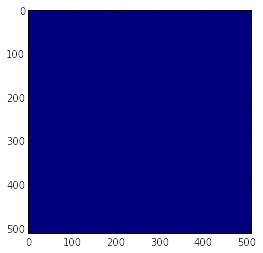

In [28]:
A_gpu
imshow(A_gpu.get())

In [29]:
textureR.prepare('P',texrefs=[texR]) # Preparamos el Kernel y pasamos la textura a usar

In [30]:
texR.set_array(matrixArray) # Paso crucial: ligamos la textura con el CUDA Array
# Ojo toda la informacion esta en el CUDA Array y ligamos a Texturas para hacer las lecturas estructuradas

In [31]:
print cuBlock
cuGrid = (16,16,1)
textureR.prepared_call(cuGrid,cuBlock,A_gpu.gpudata) 

(16, 16, 1)


<matplotlib.colorbar.Colorbar instance at 0x4ccbef0>

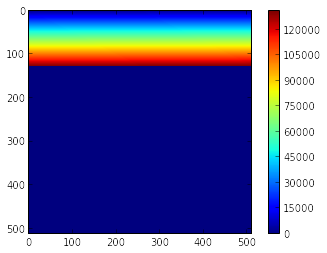

In [32]:
imshow(A_gpu.get())
colorbar()

In [33]:
A_gpu.get()

array([[  513.,   514.,   515., ...,  1278.,  1279.,  1280.],
       [ 1537.,  1538.,  1539., ...,  2302.,  2303.,  2304.],
       [ 2561.,  2562.,  2563., ...,  3326.,  3327.,  3328.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]], dtype=float32)

Una desventaje de las texturas es que los espacios de memoria que referencias no permiten escritura, es decir no existe una funcion **tex_2D_write**. Para este proposito se creo una textura con este atributo conocida como **Textura de Superficie**. *Ojo* Los CUDA Array y la texturas son dos elementos del mimo esquema: **Memoria de Texturas**, Los CUDA Array son inmutables dentro del kerne a menos que se usen texturas de Superficies

In [34]:
#Declaramos la superficie a usar (las librerias son importantes)
mySurf = '''
#include <surface_functions.h> \n
surface< void, 2> mySurf ; \n '''

In [35]:
# Observe como se modifica el Kernel
surfK = '''
__global__ void rwSurf(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float temp;
surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp); // Lectura de  Suprficie
A[tid] = temp; //Escritura a memoria global
surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),        tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
}
'''

In [36]:
print  incLib+mySurf+surfK

#include <pycuda-helpers.hpp> 

#include <surface_functions.h> 

surface< void, 2> mySurf ; 
 
__global__ void rwSurf(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float temp;
surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp); // Lectura de  Suprficie
A[tid] = temp; //Escritura a memoria global
surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),        tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
}



In [37]:
cuCode = SourceModule(incLib+mySurf+surfK)
surfRef = cuCode.get_surfref('mySurf')
surfRW = cuCode.get_function('rwSurf')

Ahora podemos escribir en el Cuda Array previamente creado 

In [38]:
surfRef.set_array(matrixArray)

In [39]:
surfRW.prepare('P')

In [40]:
surfRW.prepared_call(cuGrid,cuBlock,A_gpu.gpudata)

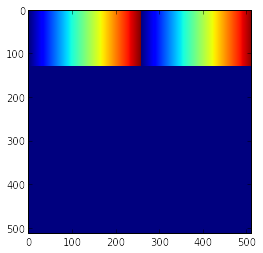

In [41]:
imshow(A_gpu.get())

In [42]:
A_gpu.get()

array([[  0.00000000e+00,   5.12000000e+02,   1.02400000e+03, ...,
          1.29537000e+05,   1.30049000e+05,   1.30561000e+05],
       [  2.00000000e+00,   5.14000000e+02,   1.02600000e+03, ...,
          1.29539000e+05,   1.30051000e+05,   1.30563000e+05],
       [  4.00000000e+00,   5.16000000e+02,   1.02800000e+03, ...,
          1.29541000e+05,   1.30053000e+05,   1.30565000e+05],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]], dtype=float32)

In [43]:
texR.set_array(matrixArray)

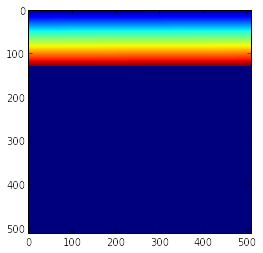

In [44]:
textureR.prepared_call(cuGrid,cuBlock,A_gpu.gpudata)
imshow(A_gpu.get())

Veamos el rendimiento de las Texturas

In [45]:
surfK2 = '''
__global__ void rwSurf(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float temp;
surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp); // Lectura de  Suprficie
A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),        tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
}
'''
cuCode = SourceModule(incLib+mySurf+surfK2)
surfRef = cuCode.get_surfref('mySurf')
surfRW = cuCode.get_function('rwSurf')

In [46]:
timeSurf = []
timeTex = []
for i in range(8,14):
    N = 2**i
    a = np.ones((N,N),dtype=np.float32)
    A_gpu=gpuarray.to_gpu(a)
    matrixArray, copyMatrixArray = np3DtoCudaArray(a,allowSurfaceBind=True) 
    cuBlock = (32,32,1)
    cuGrid   = (N/cuBlock[0],N/cuBlock[1],1)
    t1 = 0
    t2 = 0
    texR.set_array(matrixArray)
    textureR.prepare('P',texrefs=[texR]) 
    for k in range(nLoop):
        t_tex = textureR.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        t1 += t_tex()/nLoop
    surfRef.set_array(matrixArray)
    surfRW.prepare('P')
    for k in range(nLoop):
        t_surf = surfRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        t2 += t_surf()/nLoop
    
    timeSurf.append(t2)
    timeTex.append(t1)
    A_gpu.gpudata.free()
    matrixArray.free()

([<matplotlib.axis.XTick at 0x60579d0>,
 <a list of 6 Text xticklabel objects>)

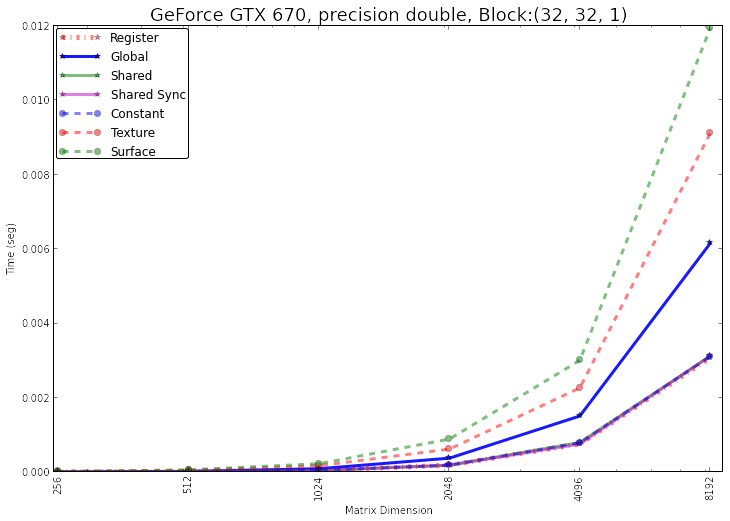

In [50]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
plt.semilogx([2**i for i in range(8,14)],timeReg,'r-.*',label='Register',linewidth=5.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeGlo,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],timeSha,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeShaSy,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeCons,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeSurf,'r--o',label='Texture',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeTex,'g--o',label='Surface',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')

###**RETO**: Repetir la prueba de rendimiento de Global, Shared y Texturas para este caso: sunponga que tiene un arreglo 2D o 3D y desea sacar el promedio de vecinos mas cercanos al punto i,j(,k) y escribirlo en un segundo arreglo en el punto i,j(,k)